In [1]:
RunningInColab = 'google.colab' in str(get_ipython())
if RunningInColab:
    from google.colab import drive
    drive.mount('/content/drive')

In [2]:
# Imports
from torch.utils.data import Dataset, DataLoader
import os
import torch
import torchaudio
import torchaudio.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torchsummary import summary

from math import ceil
from tqdm import tqdm

import matplotlib.pyplot as plt

In [3]:
# Hyperparameters
TARGET_SAMPLE_RATE = 16000
TARGET_LENGTH_SECONDS = 4
BATCH_SIZE = 128
EPOCHS = 60
LEARNING_RATE = 3e-4
DROPOUT_PROB = 0.4
DROPOUT_PROB_2D = 0.2

NUM_SAMPLES = TARGET_LENGTH_SECONDS * TARGET_SAMPLE_RATE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations
transformations = [
    transforms.MelSpectrogram(
            sample_rate=TARGET_SAMPLE_RATE,
            n_fft = 1024,
            hop_length = 512,
            n_mels = 64
        ),
]

In [4]:
class_mapping = {
  "car_horn":1,
  "dog_barking":2,
  "drilling":3,
  "Fart":4,
  "Guitar":5,
  "Gunshot_and_gunfire":6,
  "Hi-hat":7,
  "Knock":8,
  "Laughter":9,
  "Shatter":10,
  "siren":11,
  "Snare_drum":12,
  "Splash_and_splatter":13,
}

class AudioDataset(Dataset):
  def __init__(self,
               data_dir,
               transformations = transformations,
               target_sample_rate = TARGET_SAMPLE_RATE,
               num_samples = NUM_SAMPLES,
               device = device
               ):
    self.data_dir = data_dir
    self.classes = sorted(os.listdir(data_dir))
    self.file_paths = []
    self.targets = []
    self.transformations = transformations
    self.target_sample_rate = target_sample_rate
    self.num_samples = num_samples
    self.device = device

    createMapping = False
    if(len(class_mapping) == 0):createMapping = True

    for i,class_name in enumerate(self.classes):
      class_dir = os.path.join(data_dir,class_name)
      if(createMapping):class_mapping[class_name] = i

      for filename in os.listdir(class_dir):
        filepath = os.path.join(class_dir,filename)
        self.file_paths.append(filepath)
        self.targets.append(class_mapping[class_name])

  def __len__(self):
    return len(self.file_paths)

  def __getitem__(self,idx):
    audio_path = self.file_paths[idx]
    waveform, sample_rate = torchaudio.load(audio_path)
    waveform = waveform.to(self.device)
    waveform = self._resample_if_necessary(waveform,sample_rate)
    waveform = self._mix_down_if_necessary(waveform)
    waveform = self._cut_if_necessary(waveform)
    waveform = self._right_pad_if_necessary(waveform)
    

    if self.transformations:
      for transformation in self.transformations:
        waveform = transformation.to(self.device)(waveform)

    # waveform normalisation:
    waveform = torch.log1p(waveform)
    waveform = waveform * 255/(waveform.max() -waveform.min())
        
    label = self.targets[idx]
    return waveform, label

  def _resample_if_necessary(self, waveform,sample_rate):
    if sample_rate != self.target_sample_rate:
      resampler = torchaudio.transforms.Resample(sample_rate,self.target_sample_rate)
      waveform = resampler.to(self.device)(waveform)
    return waveform

  def _mix_down_if_necessary(self,waveform):
    if waveform.shape[0] > 1:
      waveform = torch.mean(waveform,dim = 0,keepdim = True)
    return waveform

  #If the video was longer than TARGET_LENGTH_SECONDS, then we are cropping it to that many seconds by removing seconds equally from both the start and the end sides
  def _cut_if_necessary(self,waveform):
    if waveform.shape[1] > self.num_samples:
      mid = (waveform.shape[1] - 1)//2
      nsby2 = self.num_samples//2
      waveform = waveform[:,mid - nsby2 + 1: mid + self.num_samples - nsby2 + 1]
    return waveform

  def _right_pad_if_necessary(self,waveform):
    num_samples = waveform.shape[1]
    if num_samples < self.num_samples:
      num_missing_samples = self.num_samples - num_samples
      last_dim_padding = (0,num_missing_samples)
      waveform = torch.nn.functional.pad(waveform,last_dim_padding)
    return waveform



# Define data directories
train_dir: str
val_dir:str
if RunningInColab:
    train_dir = "/content/drive/MyDrive/audio_dataset/train"
    val_dir = "/content/drive/MyDrive/audio_dataset/val"
else:
    train_dir = "audio_dataset/train"
    val_dir = "audio_dataset/val"

train_dataset = AudioDataset(train_dir)
val_dataset = AudioDataset(val_dir)

train_loader = DataLoader(
    train_dataset,batch_size = BATCH_SIZE, shuffle = True
)
val_loader = DataLoader(
    val_dataset,batch_size = BATCH_SIZE
)

In [5]:
class CustomResNet18(nn.Module):
    def __init__(self):
        super(CustomResNet18, self).__init__()
        self.resnet = models.resnet18(weights=None).to(device)

        self.resnet.conv1 = nn.Conv2d(1,64,kernel_size = 7,stride = 2,padding = 3,bias = False).to(device)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features,2048).to(device)
        # self.replace_batchnorm_layers(self.resnet)
        self.num_classes = len(class_mapping)

        self.resnet.conv1 = nn.Sequential(
            self.resnet.conv1,
            nn.Dropout2d(DROPOUT_PROB_2D)  # Add dropout after the first convolutional layer
        )
        # Add dropout after layers in resnet
        self.resnet.layer1 = nn.Sequential(
            self.resnet.layer1,
            nn.Dropout2d(DROPOUT_PROB_2D)  # Add dropout after layer1
        )
        self.resnet.layer2 = nn.Sequential(
            self.resnet.layer2,
            nn.Dropout2d(DROPOUT_PROB_2D)  # Add dropout after layer2
        )
        self.resnet.layer3 = nn.Sequential(
            self.resnet.layer3,
            nn.Dropout2d(DROPOUT_PROB_2D)  # Add dropout after layer3
        )
        self.resnet.layer4 = nn.Sequential(
            self.resnet.layer4,
            nn.Dropout2d(DROPOUT_PROB_2D)  # Add dropout after layer4
        )

        # Add additional linear layers
        self.additional_layers = nn.ModuleList().to(device)
        self.additional_layers.append(nn.Dropout(DROPOUT_PROB).to(device))
        self.additional_layers.append(nn.Linear(2048, 1024).to(device))
        self.additional_layers.append(nn.Linear(1024,512).to(device))
        self.additional_layers.append(nn.ReLU().to(device))
        self.additional_layers.append(nn.Linear(512,self.num_classes).to(device))

    def forward(self, x):
        x = self.resnet(x)
        for layer in self.additional_layers:
            x = layer(x)
        return x

model = CustomResNet18()
summary(model,(1,64,126))
    


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 63]           3,136
         Dropout2d-2           [-1, 64, 32, 63]               0
       BatchNorm2d-3           [-1, 64, 32, 63]             128
              ReLU-4           [-1, 64, 32, 63]               0
         MaxPool2d-5           [-1, 64, 16, 32]               0
            Conv2d-6           [-1, 64, 16, 32]          36,864
       BatchNorm2d-7           [-1, 64, 16, 32]             128
              ReLU-8           [-1, 64, 16, 32]               0
            Conv2d-9           [-1, 64, 16, 32]          36,864
      BatchNorm2d-10           [-1, 64, 16, 32]             128
             ReLU-11           [-1, 64, 16, 32]               0
       BasicBlock-12           [-1, 64, 16, 32]               0
           Conv2d-13           [-1, 64, 16, 32]          36,864
      BatchNorm2d-14           [-1, 64,

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = LEARNING_RATE)


def train_model(model, train_loader, criterion, optimizer, epoch):
  model.train()  # Set model to training mode
  running_loss = 0.0
  
  correct = 0
  total = len(train_dataset)

  num_classes = len(class_mapping)
  classwise_true_positive = torch.tensor([0]*num_classes).to(device)
  classwise_true_negative = torch.tensor([0]*num_classes).to(device)
  classwise_false_positive = torch.tensor([0]*num_classes).to(device)
  classwise_false_negative = torch.tensor([0]*num_classes).to(device)

  batch_itr = 0
  loop = tqdm(train_loader, leave=True, desc=f"Training Epoch {epoch+1}/{EPOCHS}",bar_format="{l_bar}{bar}|")

  for inputs, labels in train_loader:
    batch_itr+=1

    inputs = inputs.to(device)
    labels = labels.to(device) - torch.ones_like(labels).to(device)

    optimizer.zero_grad()

    # Forward pass
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)

    loss = criterion(outputs, labels)
    
    correct += (predicted == labels).sum().item()

    for _,class_number in class_mapping.items():
      classwise_predicted = (predicted == (class_number-1))
      classwise_labels = (labels == (class_number-1))
      classwise_true_positive[class_number-1] += torch.logical_and((classwise_predicted == classwise_labels),(classwise_predicted == 1)).sum().item()
      classwise_true_negative[class_number-1] += torch.logical_and((classwise_predicted == classwise_labels),(classwise_predicted == 0)).sum().item()
      classwise_false_positive[class_number-1] += torch.logical_and((classwise_predicted != classwise_labels),(classwise_predicted == 1)).sum().item()
      classwise_false_negative[class_number-1] += torch.logical_and((classwise_predicted != classwise_labels),(classwise_predicted == 0)).sum().item()
    

    # Backward pass and optimize
    loss.backward()
    optimizer.step()

    running_loss += loss.item() * inputs.size(0)
    loop.update()
    
  loop.close()
  
  # will have to print classwise precision accuracy and recall as well here

  epoch_loss = running_loss / len(train_loader.dataset)

  classwise_train_accuracy = (classwise_true_positive + classwise_true_negative)/(classwise_true_positive + classwise_true_negative + classwise_false_positive + classwise_false_negative)
  classwise_train_precision = (classwise_true_positive)/(classwise_true_positive + classwise_false_positive)
  classwise_train_recall = (classwise_true_positive)/(classwise_true_positive + classwise_false_negative)

  train_accuracy = correct / total
  train_precision = torch.mean(classwise_train_precision).item()
  train_recall = torch.mean(classwise_train_recall).item()

  classwise_train_accuracy = [round(element, 4) for element in classwise_train_accuracy.tolist()]
  classwise_train_precision = [round(element, 4) for element in classwise_train_precision.tolist()]
  classwise_train_recall = [round(element, 4) for element in classwise_train_recall.tolist()]

  print(f"Epoch [{epoch+1}/{EPOCHS}], Training Loss: {epoch_loss:.4f}")
  print(f'Training Accuracy: {train_accuracy:.4f}')
  print(f'Training Precision: {train_precision:.4f}')
  print(f'Training Recall: {train_recall:.4f}')
  print(f'Classwise Training Accuracy: {classwise_train_accuracy}')
  print(f'Classwise Training Precision: {classwise_train_precision}')
  print(f'Classwise Training Recall: {classwise_train_recall}\n')

  return train_accuracy,epoch_loss,train_precision,train_recall

# Validation function
def validate_model(model, val_loader):
  model.eval()  # Set model to evaluation mode
  running_loss = 0.0
  
  correct = 0
  total = len(val_dataset)
  
  num_classes = len(class_mapping)
  classwise_true_positive = torch.tensor([0]*num_classes).to(device)
  classwise_true_negative = torch.tensor([0]*num_classes).to(device)
  classwise_false_positive = torch.tensor([0]*num_classes).to(device)
  classwise_false_negative = torch.tensor([0]*num_classes).to(device)

  batch_itr = 0
  loop = tqdm(val_loader, leave=True, desc=f"Validation:",bar_format="{l_bar}{bar}|")

  with torch.no_grad(): 
    for inputs, labels in val_loader:
      batch_itr+=1

      inputs = inputs.to(device)
      labels = labels.to(device) - torch.ones_like(labels).to(device)
      outputs = model(inputs)
      _, predicted = torch.max(outputs, 1)

      loss = criterion(outputs, labels)
    
      correct += (predicted == labels).sum().item()

      for _,class_number in class_mapping.items():
        classwise_predicted = (predicted == (class_number-1))
        classwise_labels = (labels == (class_number-1))
        classwise_true_positive[class_number-1] += torch.logical_and((classwise_predicted == classwise_labels),(classwise_predicted == 1)).sum().item()
        classwise_true_negative[class_number-1] += torch.logical_and((classwise_predicted == classwise_labels),(classwise_predicted == 0)).sum().item()
        classwise_false_positive[class_number-1] += torch.logical_and((classwise_predicted != classwise_labels),(classwise_predicted == 1)).sum().item()
        classwise_false_negative[class_number-1] += torch.logical_and((classwise_predicted != classwise_labels),(classwise_predicted == 0)).sum().item()



      running_loss += loss.item() * inputs.size(0)
      loop.update()

  loop.close()

  # will have to print classwise precision accuracy and recall as well here
  
  epoch_loss = running_loss / len(val_loader.dataset)
  print(f"Validation Loss: {epoch_loss:.4f}")

  classwise_val_accuracy = (classwise_true_positive + classwise_true_negative)/(classwise_true_positive + classwise_true_negative + classwise_false_positive + classwise_false_negative)
  classwise_val_precision = (classwise_true_positive)/(classwise_true_positive + classwise_false_positive)
  classwise_val_recall = (classwise_true_positive)/(classwise_true_positive + classwise_false_negative)

  val_accuracy = correct / total
  val_precision = torch.mean(classwise_val_precision).item()
  val_recall = torch.mean(classwise_val_recall).item()

  classwise_val_accuracy = [round(element, 4) for element in classwise_val_accuracy.tolist()]
  classwise_val_precision = [round(element, 4) for element in classwise_val_precision.tolist()]
  classwise_val_recall = [round(element, 4) for element in classwise_val_recall.tolist()]

  print(f'Validation Accuracy: {val_accuracy:.4f}')
  print(f'Validation Precision: {val_precision:.4f}')
  print(f'Validation Recall: {val_recall:.4f}')
  print(f'Classwise Validation Accuracy: {classwise_val_accuracy}')
  print(f'Classwise Validation Precision: {classwise_val_precision}')
  print(f'Classwise Validation Recall: {classwise_val_recall}\n')

  return val_accuracy,epoch_loss,val_precision,val_recall

In [7]:
# Training Loop
best_accuracy = 0.0

train_accuracy_list=[]
train_loss_list=[]
train_precision_list=[]
train_recall_list=[]
val_accuracy_list=[]
val_loss_list=[]
val_precision_list=[]
val_recall_list=[]

for epoch in range(EPOCHS):
  train_acc,train_loss,train_prec,train_rec = train_model(model,train_loader,criterion,optimizer,epoch)
  train_accuracy_list.append(train_acc)
  train_loss_list.append(train_loss)
  train_precision_list.append(train_prec)
  train_recall_list.append(train_rec)

  val_acc,val_loss,val_prec,val_rec = validate_model(model, val_loader)
  val_accuracy_list.append(val_acc)
  val_loss_list.append(val_loss)
  val_precision_list.append(val_prec)
  val_recall_list.append(val_rec)

  if((epoch+1) % 10 == 0 or (epoch+1) == EPOCHS):
    filename = f"epoch{epoch+1}_{val_acc * 100:.2f}"
    torch.save(model.state_dict(),os.path.join("model1_every10epochs",filename))
  if val_acc > best_accuracy:best_accuracy = val_acc

  print(f"Best Validation Accuracy: {best_accuracy:.4f}\n")

Training Epoch 1/60: 100%|██████████|


Epoch [1/60], Training Loss: 1.8963
Training Accuracy: 0.3588
Training Precision: 0.2849
Training Recall: 0.2650
Classwise Training Accuracy: [0.9245, 0.8314, 0.8895, 0.9197, 0.8156, 0.8695, 0.9625, 0.9646, 0.9319, 0.9527, 0.853, 0.8403, 0.9625]
Classwise Training Precision: [0.3678, 0.3961, 0.5188, 0.2585, 0.2847, 0.2459, 0.2381, 0.0, 0.275, 0.2955, 0.4049, 0.327, 0.0909]
Classwise Training Recall: [0.093, 0.5328, 0.5679, 0.1821, 0.4197, 0.2009, 0.0292, 0.0, 0.0746, 0.0613, 0.5857, 0.692, 0.0058]



Validation:: 100%|██████████|


Validation Loss: 1.3382
Validation Accuracy: 0.5517
Validation Precision: 0.5197
Validation Recall: 0.4492
Classwise Validation Accuracy: [0.9404, 0.8892, 0.9471, 0.9404, 0.8784, 0.885, 0.9578, 0.9562, 0.9371, 0.9537, 0.9479, 0.9057, 0.9644]
Classwise Validation Precision: [0.697, 0.5657, 0.7923, 0.5, 0.4737, 0.3969, 0.4043, 0.2857, 0.44, 0.4571, 0.7484, 0.4951, 0.5]
Classwise Validation Recall: [0.2706, 0.7, 0.7357, 0.0556, 0.7279, 0.4643, 0.4524, 0.1951, 0.1507, 0.3019, 0.8286, 0.9107, 0.0465]

Best Validation Accuracy: 0.5517



Training Epoch 2/60: 100%|██████████|


Epoch [2/60], Training Loss: 1.2352
Training Accuracy: 0.6044
Training Precision: 0.5606
Training Recall: 0.5309
Classwise Training Accuracy: [0.9465, 0.8915, 0.9387, 0.9304, 0.9053, 0.9162, 0.971, 0.9629, 0.93, 0.95, 0.9516, 0.9541, 0.9605]
Classwise Training Precision: [0.6826, 0.5769, 0.7435, 0.4307, 0.5738, 0.538, 0.6087, 0.4143, 0.4211, 0.4221, 0.7816, 0.7119, 0.3827]
Classwise Training Recall: [0.4564, 0.6625, 0.7143, 0.5017, 0.6241, 0.6473, 0.4912, 0.1726, 0.4068, 0.3962, 0.8054, 0.8438, 0.1792]



Validation:: 100%|██████████|


Validation Loss: 1.0384
Validation Accuracy: 0.6510
Validation Precision: 0.6730
Validation Recall: 0.5742
Classwise Validation Accuracy: [0.957, 0.8784, 0.9578, 0.9553, 0.9322, 0.9446, 0.9661, 0.9694, 0.9446, 0.9421, 0.9653, 0.9735, 0.9156]
Classwise Validation Precision: [0.6941, 0.527, 0.9009, 0.6875, 0.7647, 0.732, 1.0, 0.6111, 0.5625, 0.3924, 0.8356, 0.8175, 0.2243]
Classwise Validation Recall: [0.6941, 0.7937, 0.7143, 0.4583, 0.5735, 0.6339, 0.0238, 0.2683, 0.3699, 0.5849, 0.8714, 0.9196, 0.5581]

Best Validation Accuracy: 0.6510



Training Epoch 3/60: 100%|██████████|


Epoch [3/60], Training Loss: 0.9353
Training Accuracy: 0.7005
Training Precision: 0.6521
Training Recall: 0.6466
Classwise Training Accuracy: [0.9555, 0.9251, 0.9461, 0.9417, 0.9442, 0.9467, 0.9751, 0.9675, 0.9533, 0.9545, 0.965, 0.9699, 0.9564]
Classwise Training Precision: [0.6905, 0.7047, 0.777, 0.5117, 0.757, 0.7015, 0.6562, 0.5301, 0.6288, 0.4767, 0.8445, 0.8283, 0.3709]
Classwise Training Recall: [0.6744, 0.7422, 0.7464, 0.6014, 0.7445, 0.7344, 0.614, 0.5238, 0.5627, 0.434, 0.8536, 0.8504, 0.3237]



Validation:: 100%|██████████|


Validation Loss: 0.9168
Validation Accuracy: 0.7221
Validation Precision: 0.7009
Validation Recall: 0.6881
Classwise Validation Accuracy: [0.9694, 0.9289, 0.9636, 0.952, 0.9512, 0.9413, 0.981, 0.9777, 0.9495, 0.9438, 0.9677, 0.9735, 0.9446]
Classwise Validation Precision: [0.8529, 0.7056, 0.9364, 0.625, 0.9326, 0.6395, 0.7111, 0.6842, 0.6364, 0.4194, 0.8531, 0.803, 0.3125]
Classwise Validation Recall: [0.6824, 0.7937, 0.7357, 0.4861, 0.6103, 0.8393, 0.7619, 0.6341, 0.3836, 0.7358, 0.8714, 0.9464, 0.4651]

Best Validation Accuracy: 0.7221



Training Epoch 4/60: 100%|██████████|


Epoch [4/60], Training Loss: 0.7820
Training Accuracy: 0.7468
Training Precision: 0.7034
Training Recall: 0.7029
Classwise Training Accuracy: [0.9683, 0.9366, 0.9572, 0.9467, 0.9545, 0.9533, 0.9807, 0.9753, 0.9551, 0.9578, 0.9691, 0.978, 0.9611]
Classwise Training Precision: [0.7811, 0.761, 0.8372, 0.5473, 0.8022, 0.7307, 0.7421, 0.6237, 0.6305, 0.5178, 0.8661, 0.8651, 0.4394]
Classwise Training Recall: [0.7674, 0.7563, 0.7804, 0.6357, 0.792, 0.7812, 0.6901, 0.7202, 0.6305, 0.4811, 0.8661, 0.9018, 0.3353]



Validation:: 100%|██████████|


Validation Loss: 0.7297
Validation Accuracy: 0.7659
Validation Precision: 0.7371
Validation Recall: 0.7432
Classwise Validation Accuracy: [0.9752, 0.9504, 0.9686, 0.9247, 0.9653, 0.9653, 0.9868, 0.9727, 0.9471, 0.9628, 0.9711, 0.981, 0.9611]
Classwise Validation Precision: [0.8235, 0.8623, 0.9554, 0.4215, 0.9196, 0.7869, 0.8611, 0.5714, 0.5789, 0.5645, 0.8723, 0.9009, 0.4643]
Classwise Validation Recall: [0.8235, 0.7437, 0.7643, 0.7083, 0.7574, 0.8571, 0.7381, 0.7805, 0.4521, 0.6604, 0.8786, 0.8929, 0.6047]

Best Validation Accuracy: 0.7659



Training Epoch 5/60: 100%|██████████|


Epoch [5/60], Training Loss: 0.6370
Training Accuracy: 0.7927
Training Precision: 0.7613
Training Recall: 0.7633
Classwise Training Accuracy: [0.9739, 0.9498, 0.9629, 0.9566, 0.9599, 0.9654, 0.9848, 0.9833, 0.9584, 0.9654, 0.9755, 0.9804, 0.9691]
Classwise Training Precision: [0.8239, 0.8194, 0.8532, 0.6299, 0.8227, 0.8125, 0.8212, 0.7208, 0.6587, 0.5991, 0.8889, 0.8763, 0.5706]
Classwise Training Recall: [0.8023, 0.7937, 0.8196, 0.6667, 0.8212, 0.8125, 0.7251, 0.8452, 0.6542, 0.6274, 0.9, 0.9174, 0.5376]



Validation:: 100%|██████████|


Validation Loss: 0.5985
Validation Accuracy: 0.8098
Validation Precision: 0.7914
Validation Recall: 0.7869
Classwise Validation Accuracy: [0.9768, 0.9512, 0.9694, 0.9669, 0.9719, 0.9694, 0.9868, 0.9876, 0.9644, 0.9595, 0.9686, 0.9826, 0.9644]
Classwise Validation Precision: [0.8065, 0.8301, 0.8992, 0.75, 0.918, 0.8099, 1.0, 0.7826, 0.6974, 0.5263, 0.8984, 0.8699, 0.5]
Classwise Validation Recall: [0.8824, 0.7937, 0.8286, 0.6667, 0.8235, 0.875, 0.619, 0.878, 0.726, 0.7547, 0.8214, 0.9554, 0.6047]

Best Validation Accuracy: 0.8098



Training Epoch 6/60: 100%|██████████|


Epoch [6/60], Training Loss: 0.5683
Training Accuracy: 0.8178
Training Precision: 0.7928
Training Recall: 0.7894
Classwise Training Accuracy: [0.9798, 0.9559, 0.9642, 0.9621, 0.9634, 0.9667, 0.9864, 0.986, 0.9675, 0.9718, 0.9794, 0.9819, 0.9706]
Classwise Training Precision: [0.8618, 0.8381, 0.8496, 0.6754, 0.8351, 0.8109, 0.8477, 0.7874, 0.7276, 0.6777, 0.9122, 0.8913, 0.5915]
Classwise Training Recall: [0.8517, 0.825, 0.8375, 0.7079, 0.8412, 0.8326, 0.7485, 0.8155, 0.7424, 0.6745, 0.9089, 0.9152, 0.5607]



Validation:: 100%|██████████|


Validation Loss: 0.5824
Validation Accuracy: 0.8280
Validation Precision: 0.8144
Validation Recall: 0.8147
Classwise Validation Accuracy: [0.9801, 0.952, 0.9752, 0.9711, 0.9735, 0.9727, 0.9876, 0.9876, 0.9677, 0.9653, 0.9793, 0.9669, 0.9768]
Classwise Validation Precision: [0.828, 0.7865, 0.9911, 0.7761, 0.9483, 0.9158, 0.8649, 0.7708, 0.7833, 0.5647, 0.9137, 0.7609, 0.6829]
Classwise Validation Recall: [0.9059, 0.875, 0.7929, 0.7222, 0.8088, 0.7768, 0.7619, 0.9024, 0.6438, 0.9057, 0.9071, 0.9375, 0.6512]

Best Validation Accuracy: 0.8280



Training Epoch 7/60: 100%|██████████|


Epoch [7/60], Training Loss: 0.5092
Training Accuracy: 0.8318
Training Precision: 0.8046
Training Recall: 0.8029
Classwise Training Accuracy: [0.9772, 0.9557, 0.9679, 0.9699, 0.9722, 0.9708, 0.986, 0.985, 0.9685, 0.9699, 0.9811, 0.986, 0.9734]
Classwise Training Precision: [0.8437, 0.8284, 0.8741, 0.7425, 0.8668, 0.8509, 0.8323, 0.7654, 0.7483, 0.6473, 0.9134, 0.9148, 0.6325]
Classwise Training Recall: [0.8314, 0.8375, 0.8429, 0.7629, 0.8905, 0.8281, 0.7544, 0.8155, 0.7254, 0.684, 0.9232, 0.9353, 0.6069]



Validation:: 100%|██████████|


Validation Loss: 0.5266
Validation Accuracy: 0.8453
Validation Precision: 0.8238
Validation Recall: 0.8167
Classwise Validation Accuracy: [0.9876, 0.9686, 0.9744, 0.9677, 0.9735, 0.9644, 0.9892, 0.9859, 0.9719, 0.9694, 0.9851, 0.9801, 0.9727]
Classwise Validation Precision: [0.9487, 0.8765, 0.9504, 0.7895, 0.9, 0.7518, 0.9143, 0.7609, 0.8, 0.66, 0.9236, 0.8438, 0.5893]
Classwise Validation Recall: [0.8706, 0.8875, 0.8214, 0.625, 0.8603, 0.9196, 0.7619, 0.8537, 0.7123, 0.6226, 0.95, 0.9643, 0.7674]

Best Validation Accuracy: 0.8453



Training Epoch 8/60: 100%|██████████|


Epoch [8/60], Training Loss: 0.4188
Training Accuracy: 0.8631
Training Precision: 0.8414
Training Recall: 0.8393
Classwise Training Accuracy: [0.9858, 0.965, 0.9755, 0.973, 0.9763, 0.9757, 0.9864, 0.9901, 0.9745, 0.9757, 0.9833, 0.9864, 0.9784]
Classwise Training Precision: [0.8986, 0.8615, 0.9031, 0.7649, 0.8845, 0.8784, 0.8431, 0.8371, 0.7879, 0.7136, 0.9315, 0.9263, 0.7073]
Classwise Training Recall: [0.9012, 0.875, 0.8821, 0.7938, 0.9088, 0.8549, 0.7544, 0.8869, 0.7932, 0.7406, 0.9232, 0.9263, 0.6705]



Validation:: 100%|██████████|


Validation Loss: 0.6738
Validation Accuracy: 0.8271
Validation Precision: 0.8090
Validation Recall: 0.8196
Classwise Validation Accuracy: [0.9835, 0.9479, 0.9735, 0.9719, 0.9777, 0.9785, 0.9884, 0.9851, 0.9653, 0.9636, 0.9702, 0.9801, 0.9686]
Classwise Validation Precision: [0.8652, 0.787, 0.9909, 0.7794, 0.9504, 0.8707, 0.9375, 0.7018, 0.7123, 0.5495, 0.9727, 0.8438, 0.5556]
Classwise Validation Recall: [0.9059, 0.8313, 0.7786, 0.7361, 0.8456, 0.9018, 0.7143, 0.9756, 0.7123, 0.9434, 0.7643, 0.9643, 0.5814]

Best Validation Accuracy: 0.8453



Training Epoch 9/60: 100%|██████████|


Epoch [9/60], Training Loss: 0.4231
Training Accuracy: 0.8619
Training Precision: 0.8405
Training Recall: 0.8406
Classwise Training Accuracy: [0.9844, 0.9619, 0.9741, 0.9708, 0.9774, 0.9759, 0.9866, 0.9874, 0.9755, 0.978, 0.9837, 0.987, 0.9811]
Classwise Training Precision: [0.8895, 0.8583, 0.8931, 0.7614, 0.8911, 0.8702, 0.8272, 0.8129, 0.7857, 0.7512, 0.9333, 0.9268, 0.7263]
Classwise Training Recall: [0.8895, 0.8516, 0.8804, 0.7457, 0.9106, 0.8683, 0.7836, 0.8274, 0.8203, 0.7406, 0.925, 0.933, 0.7514]



Validation:: 100%|██████████|


Validation Loss: 0.5879
Validation Accuracy: 0.8255
Validation Precision: 0.8122
Validation Recall: 0.8077
Classwise Validation Accuracy: [0.981, 0.9702, 0.9752, 0.9595, 0.976, 0.9768, 0.9851, 0.9942, 0.957, 0.9562, 0.9826, 0.9843, 0.9529]
Classwise Validation Precision: [0.837, 0.9493, 0.9167, 0.96, 0.982, 0.92, 0.8, 0.8864, 0.5913, 0.5, 0.9343, 0.8908, 0.3906]
Classwise Validation Recall: [0.9059, 0.8188, 0.8643, 0.3333, 0.8015, 0.8214, 0.7619, 0.9512, 0.9315, 0.8679, 0.9143, 0.9464, 0.5814]

Best Validation Accuracy: 0.8453



Training Epoch 10/60: 100%|██████████|


Epoch [10/60], Training Loss: 0.3625
Training Accuracy: 0.8868
Training Precision: 0.8690
Training Recall: 0.8655
Classwise Training Accuracy: [0.9887, 0.9712, 0.9769, 0.9761, 0.9831, 0.9813, 0.9876, 0.9922, 0.9798, 0.9809, 0.985, 0.9895, 0.9813]
Classwise Training Precision: [0.9238, 0.8823, 0.9088, 0.7907, 0.9267, 0.9048, 0.8627, 0.8824, 0.8408, 0.7668, 0.934, 0.9287, 0.744]
Classwise Training Recall: [0.9157, 0.9016, 0.8893, 0.8179, 0.9234, 0.8906, 0.7719, 0.8929, 0.8237, 0.8066, 0.9357, 0.9598, 0.7225]



Validation:: 100%|██████████|


Validation Loss: 0.4184
Validation Accuracy: 0.8751
Validation Precision: 0.8619
Validation Recall: 0.8587
Classwise Validation Accuracy: [0.9826, 0.9653, 0.9818, 0.9793, 0.9801, 0.9727, 0.9884, 0.9901, 0.9727, 0.9843, 0.9826, 0.9892, 0.981]
Classwise Validation Precision: [0.8478, 0.8782, 0.9214, 0.8983, 0.9308, 0.816, 0.9375, 0.7843, 0.7857, 0.8542, 0.9281, 0.9304, 0.6923]
Classwise Validation Recall: [0.9176, 0.8562, 0.9214, 0.7361, 0.8897, 0.9107, 0.7143, 0.9756, 0.7534, 0.7736, 0.9214, 0.9554, 0.8372]

Best Validation Accuracy: 0.8751



Training Epoch 11/60: 100%|██████████|


Epoch [11/60], Training Loss: 0.3236
Training Accuracy: 0.8952
Training Precision: 0.8741
Training Recall: 0.8715
Classwise Training Accuracy: [0.9899, 0.9767, 0.9784, 0.978, 0.9839, 0.9825, 0.9881, 0.9922, 0.9817, 0.978, 0.9895, 0.9901, 0.9815]
Classwise Training Precision: [0.9275, 0.923, 0.8957, 0.8309, 0.9288, 0.9007, 0.8645, 0.8736, 0.8433, 0.7465, 0.9537, 0.9329, 0.7427]
Classwise Training Recall: [0.9302, 0.8984, 0.9196, 0.7938, 0.9288, 0.9107, 0.7836, 0.9048, 0.8576, 0.75, 0.9554, 0.9621, 0.7341]



Validation:: 100%|██████████|


Validation Loss: 0.4444
Validation Accuracy: 0.8743
Validation Precision: 0.8534
Validation Recall: 0.8437
Classwise Validation Accuracy: [0.9851, 0.9644, 0.9843, 0.9785, 0.981, 0.9818, 0.9884, 0.9801, 0.9694, 0.9859, 0.9859, 0.9868, 0.9768]
Classwise Validation Precision: [0.8764, 0.8545, 0.969, 0.9107, 0.8951, 0.875, 0.8889, 0.6441, 0.7647, 0.8462, 0.9424, 0.9, 0.7273]
Classwise Validation Recall: [0.9176, 0.8813, 0.8929, 0.7083, 0.9412, 0.9375, 0.7619, 0.9268, 0.7123, 0.8302, 0.9357, 0.9643, 0.5581]

Best Validation Accuracy: 0.8751



Training Epoch 12/60: 100%|██████████|


Epoch [12/60], Training Loss: 0.2776
Training Accuracy: 0.9088
Training Precision: 0.8927
Training Recall: 0.8909
Classwise Training Accuracy: [0.9903, 0.9751, 0.9821, 0.9811, 0.9862, 0.9846, 0.9901, 0.9922, 0.9837, 0.9848, 0.9909, 0.992, 0.9846]
Classwise Training Precision: [0.9355, 0.91, 0.9216, 0.8491, 0.9349, 0.921, 0.8868, 0.8779, 0.8649, 0.8136, 0.9558, 0.9455, 0.7882]
Classwise Training Recall: [0.9273, 0.9, 0.9232, 0.8316, 0.9434, 0.9107, 0.8246, 0.8988, 0.8678, 0.8443, 0.9661, 0.9688, 0.7746]



Validation:: 100%|██████████|


Validation Loss: 0.4359
Validation Accuracy: 0.8809
Validation Precision: 0.8651
Validation Recall: 0.8666
Classwise Validation Accuracy: [0.9876, 0.9669, 0.9835, 0.9793, 0.9818, 0.981, 0.9917, 0.9917, 0.9702, 0.9744, 0.9884, 0.9909, 0.9744]
Classwise Validation Precision: [0.907, 0.8409, 0.9478, 0.9608, 0.9914, 0.887, 0.9444, 0.8298, 0.7681, 0.6375, 0.9773, 0.9391, 0.6154]
Classwise Validation Recall: [0.9176, 0.925, 0.9071, 0.6806, 0.8456, 0.9107, 0.8095, 0.9512, 0.726, 0.9623, 0.9214, 0.9643, 0.7442]

Best Validation Accuracy: 0.8809



Training Epoch 13/60: 100%|██████████|


Epoch [13/60], Training Loss: 0.2691
Training Accuracy: 0.9094
Training Precision: 0.8954
Training Recall: 0.8915
Classwise Training Accuracy: [0.9891, 0.9792, 0.9835, 0.9784, 0.9858, 0.9813, 0.9903, 0.9934, 0.9854, 0.985, 0.9909, 0.9903, 0.9862]
Classwise Training Precision: [0.9267, 0.9218, 0.927, 0.8321, 0.93, 0.8923, 0.9079, 0.8953, 0.8836, 0.8174, 0.9624, 0.9387, 0.8046]
Classwise Training Recall: [0.9186, 0.9203, 0.9304, 0.8007, 0.9453, 0.9062, 0.807, 0.9167, 0.8746, 0.8443, 0.9589, 0.9576, 0.8092]



Validation:: 100%|██████████|


Validation Loss: 0.5322
Validation Accuracy: 0.8685
Validation Precision: 0.8565
Validation Recall: 0.8620
Classwise Validation Accuracy: [0.9909, 0.9644, 0.9744, 0.962, 0.9876, 0.9793, 0.9859, 0.9959, 0.9735, 0.9826, 0.9859, 0.9876, 0.9669]
Classwise Validation Precision: [0.9512, 0.968, 0.8344, 0.63, 0.984, 0.9888, 0.7907, 0.95, 0.7733, 0.8636, 0.9424, 0.9369, 0.5205]
Classwise Validation Recall: [0.9176, 0.7563, 0.9714, 0.875, 0.9044, 0.7857, 0.8095, 0.9268, 0.7945, 0.717, 0.9357, 0.9286, 0.8837]

Best Validation Accuracy: 0.8809



Training Epoch 14/60: 100%|██████████|


Epoch [14/60], Training Loss: 0.2706
Training Accuracy: 0.9121
Training Precision: 0.9012
Training Recall: 0.9029
Classwise Training Accuracy: [0.9907, 0.9757, 0.978, 0.9794, 0.9866, 0.9846, 0.9907, 0.9946, 0.9879, 0.9866, 0.9893, 0.9909, 0.9891]
Classwise Training Precision: [0.9235, 0.9117, 0.9096, 0.8328, 0.9383, 0.9229, 0.9091, 0.9128, 0.8907, 0.8356, 0.9568, 0.9489, 0.8226]
Classwise Training Recall: [0.9477, 0.9031, 0.8982, 0.8213, 0.9434, 0.9085, 0.8187, 0.9345, 0.9119, 0.8632, 0.95, 0.9531, 0.8844]



Validation:: 100%|██████████|


Validation Loss: 0.3837
Validation Accuracy: 0.8850
Validation Precision: 0.8694
Validation Recall: 0.8628
Classwise Validation Accuracy: [0.9892, 0.9711, 0.9868, 0.9793, 0.9768, 0.9835, 0.9868, 0.9967, 0.9727, 0.9818, 0.9868, 0.9835, 0.9752]
Classwise Validation Precision: [0.9186, 0.8931, 0.9429, 0.8983, 0.875, 0.8833, 0.825, 0.9512, 0.8448, 0.8163, 0.9429, 0.8966, 0.614]
Classwise Validation Recall: [0.9294, 0.8875, 0.9429, 0.7361, 0.9265, 0.9464, 0.7857, 0.9512, 0.6712, 0.7547, 0.9429, 0.9286, 0.814]

Best Validation Accuracy: 0.8850



Training Epoch 15/60: 100%|██████████|


Epoch [15/60], Training Loss: 0.2214
Training Accuracy: 0.9286
Training Precision: 0.9207
Training Recall: 0.9178
Classwise Training Accuracy: [0.992, 0.9827, 0.9868, 0.9848, 0.9858, 0.9856, 0.9916, 0.9949, 0.987, 0.9922, 0.9914, 0.9914, 0.9911]
Classwise Training Precision: [0.9472, 0.9277, 0.9397, 0.8754, 0.9362, 0.9257, 0.9062, 0.9133, 0.9028, 0.9028, 0.9642, 0.9452, 0.8824]
Classwise Training Recall: [0.939, 0.9422, 0.9464, 0.8694, 0.938, 0.9174, 0.848, 0.9405, 0.8814, 0.9198, 0.9607, 0.9621, 0.8671]



Validation:: 100%|██████████|


Validation Loss: 0.4047
Validation Accuracy: 0.8842
Validation Precision: 0.8757
Validation Recall: 0.8639
Classwise Validation Accuracy: [0.9917, 0.9694, 0.9843, 0.976, 0.9835, 0.9801, 0.9901, 0.9926, 0.9744, 0.9843, 0.9868, 0.981, 0.9744]
Classwise Validation Precision: [0.963, 0.8514, 0.9481, 0.8525, 0.9531, 0.8929, 0.9167, 0.9, 0.8088, 0.9048, 0.9493, 0.856, 0.5882]
Classwise Validation Recall: [0.9176, 0.9312, 0.9143, 0.7222, 0.8971, 0.8929, 0.7857, 0.878, 0.7534, 0.717, 0.9357, 0.9554, 0.9302]

Best Validation Accuracy: 0.8850



Training Epoch 16/60: 100%|██████████|


Epoch [16/60], Training Loss: 0.1843
Training Accuracy: 0.9387
Training Precision: 0.9266
Training Recall: 0.9231
Classwise Training Accuracy: [0.9949, 0.9876, 0.9889, 0.9876, 0.9879, 0.9885, 0.9909, 0.9957, 0.9907, 0.9876, 0.9955, 0.9924, 0.9891]
Classwise Training Precision: [0.965, 0.956, 0.9502, 0.8863, 0.9374, 0.9434, 0.8848, 0.9509, 0.9167, 0.8585, 0.9821, 0.9536, 0.8614]
Classwise Training Recall: [0.9622, 0.95, 0.9536, 0.9107, 0.9562, 0.9308, 0.8538, 0.9226, 0.9322, 0.8585, 0.9786, 0.9643, 0.8266]



Validation:: 100%|██████████|


Validation Loss: 0.4723
Validation Accuracy: 0.8817
Validation Precision: 0.8586
Validation Recall: 0.8686
Classwise Validation Accuracy: [0.9851, 0.976, 0.9801, 0.9735, 0.9868, 0.9843, 0.9901, 0.9892, 0.9735, 0.9768, 0.9917, 0.9884, 0.9677]
Classwise Validation Precision: [0.8681, 0.9119, 0.9603, 0.9348, 0.9615, 0.9346, 0.8947, 0.7692, 0.8154, 0.7049, 0.971, 0.9083, 0.5263]
Classwise Validation Recall: [0.9294, 0.9062, 0.8643, 0.5972, 0.9191, 0.8929, 0.8095, 0.9756, 0.726, 0.8113, 0.9571, 0.9732, 0.9302]

Best Validation Accuracy: 0.8850



Training Epoch 17/60: 100%|██████████|


Epoch [17/60], Training Loss: 0.1903
Training Accuracy: 0.9387
Training Precision: 0.9289
Training Recall: 0.9280
Classwise Training Accuracy: [0.9944, 0.9837, 0.9879, 0.9881, 0.9893, 0.9895, 0.9918, 0.9946, 0.9899, 0.9918, 0.9942, 0.9911, 0.9909]
Classwise Training Precision: [0.9594, 0.9431, 0.9497, 0.8896, 0.9542, 0.9401, 0.9068, 0.908, 0.9212, 0.8981, 0.9733, 0.9451, 0.8862]
Classwise Training Recall: [0.9622, 0.9328, 0.9446, 0.9141, 0.9507, 0.9464, 0.8538, 0.9405, 0.9119, 0.9151, 0.9768, 0.9598, 0.8555]



Validation:: 100%|██████████|


Validation Loss: 0.4485
Validation Accuracy: 0.8867
Validation Precision: 0.8702
Validation Recall: 0.8749
Classwise Validation Accuracy: [0.9892, 0.9702, 0.9777, 0.9777, 0.9826, 0.9843, 0.9843, 0.9926, 0.9719, 0.9851, 0.9859, 0.9901, 0.9818]
Classwise Validation Precision: [0.8913, 0.9306, 0.938, 0.9091, 0.9259, 0.8974, 0.7255, 0.9706, 0.701, 0.7778, 0.9301, 0.9717, 0.7442]
Classwise Validation Recall: [0.9647, 0.8375, 0.8643, 0.6944, 0.9191, 0.9375, 0.881, 0.8049, 0.9315, 0.9245, 0.95, 0.9196, 0.7442]

Best Validation Accuracy: 0.8867



Training Epoch 18/60: 100%|██████████|


Epoch [18/60], Training Loss: 0.1599
Training Accuracy: 0.9442
Training Precision: 0.9328
Training Recall: 0.9318
Classwise Training Accuracy: [0.9949, 0.9852, 0.9901, 0.9899, 0.9918, 0.9938, 0.9909, 0.9969, 0.992, 0.9874, 0.9924, 0.9926, 0.9905]
Classwise Training Precision: [0.9623, 0.9424, 0.9539, 0.9261, 0.9669, 0.9707, 0.8944, 0.9474, 0.9324, 0.8545, 0.9695, 0.9478, 0.8588]
Classwise Training Recall: [0.9651, 0.9453, 0.9607, 0.9038, 0.9599, 0.9621, 0.8421, 0.9643, 0.9356, 0.8585, 0.9643, 0.9732, 0.8786]



Validation:: 100%|██████████|


Validation Loss: 0.4417
Validation Accuracy: 0.8916
Validation Precision: 0.8793
Validation Recall: 0.8799
Classwise Validation Accuracy: [0.9892, 0.9711, 0.9868, 0.9793, 0.9777, 0.9851, 0.9892, 0.9926, 0.9777, 0.9859, 0.9818, 0.9851, 0.9818]
Classwise Validation Precision: [0.9186, 0.8882, 0.9366, 0.9434, 0.9431, 0.9196, 0.8919, 0.8478, 0.8286, 0.8462, 0.9041, 0.8852, 0.678]
Classwise Validation Recall: [0.9294, 0.8938, 0.95, 0.6944, 0.8529, 0.9196, 0.7857, 0.9512, 0.7945, 0.8302, 0.9429, 0.9643, 0.9302]

Best Validation Accuracy: 0.8916



Training Epoch 19/60: 100%|██████████|


Epoch [19/60], Training Loss: 0.1616
Training Accuracy: 0.9463
Training Precision: 0.9407
Training Recall: 0.9406
Classwise Training Accuracy: [0.9965, 0.9811, 0.9899, 0.992, 0.9909, 0.9918, 0.9928, 0.9969, 0.9911, 0.9934, 0.9903, 0.9934, 0.9924]
Classwise Training Precision: [0.9795, 0.9268, 0.9571, 0.9375, 0.9599, 0.9533, 0.9048, 0.9527, 0.9257, 0.9245, 0.9605, 0.9602, 0.8864]
Classwise Training Recall: [0.9709, 0.9297, 0.9554, 0.9278, 0.9599, 0.9576, 0.8889, 0.9583, 0.9288, 0.9245, 0.9554, 0.9688, 0.9017]



Validation:: 100%|██████████|


Validation Loss: 0.5152
Validation Accuracy: 0.8734
Validation Precision: 0.8666
Validation Recall: 0.8504
Classwise Validation Accuracy: [0.9826, 0.9628, 0.9727, 0.976, 0.9801, 0.9835, 0.9884, 0.9942, 0.9735, 0.9843, 0.9793, 0.9926, 0.9768]
Classwise Validation Precision: [0.82, 0.8758, 0.8452, 0.9574, 0.9058, 0.9107, 0.8333, 0.8864, 0.8868, 0.8696, 0.8662, 0.9558, 0.6531]
Classwise Validation Recall: [0.9647, 0.8375, 0.9357, 0.625, 0.9191, 0.9107, 0.8333, 0.9512, 0.6438, 0.7547, 0.9714, 0.9643, 0.7442]

Best Validation Accuracy: 0.8916



Training Epoch 20/60: 100%|██████████|


Epoch [20/60], Training Loss: 0.1706
Training Accuracy: 0.9452
Training Precision: 0.9393
Training Recall: 0.9363
Classwise Training Accuracy: [0.9953, 0.9881, 0.9885, 0.9879, 0.9881, 0.9905, 0.9949, 0.9959, 0.9907, 0.9914, 0.9938, 0.9926, 0.993]
Classwise Training Precision: [0.9679, 0.9619, 0.9452, 0.9028, 0.9455, 0.9447, 0.9563, 0.9302, 0.9139, 0.9167, 0.9682, 0.9558, 0.9017]
Classwise Training Recall: [0.9651, 0.9469, 0.9554, 0.8935, 0.9489, 0.9531, 0.8947, 0.9524, 0.9356, 0.8821, 0.9786, 0.9643, 0.9017]



Validation:: 100%|██████████|


Validation Loss: 0.4773
Validation Accuracy: 0.8966
Validation Precision: 0.8854
Validation Recall: 0.8672
Classwise Validation Accuracy: [0.9868, 0.9677, 0.9884, 0.9801, 0.9835, 0.9868, 0.9909, 0.9926, 0.9744, 0.9843, 0.9876, 0.9917, 0.9785]
Classwise Validation Precision: [0.871, 0.8497, 0.95, 0.9444, 0.9394, 0.9364, 0.9189, 0.9211, 0.75, 0.7833, 0.9562, 0.9322, 0.7576]
Classwise Validation Recall: [0.9529, 0.9187, 0.95, 0.7083, 0.9118, 0.9196, 0.8095, 0.8537, 0.863, 0.8868, 0.9357, 0.9821, 0.5814]

Best Validation Accuracy: 0.8966



Training Epoch 21/60: 100%|██████████|


Epoch [21/60], Training Loss: 0.1467
Training Accuracy: 0.9506
Training Precision: 0.9419
Training Recall: 0.9400
Classwise Training Accuracy: [0.9946, 0.9864, 0.9916, 0.9914, 0.9936, 0.9907, 0.9934, 0.9955, 0.9901, 0.992, 0.9944, 0.9951, 0.9924]
Classwise Training Precision: [0.9676, 0.9484, 0.9561, 0.9368, 0.9709, 0.9468, 0.9212, 0.9345, 0.9049, 0.9023, 0.9802, 0.9753, 0.9]
Classwise Training Recall: [0.9564, 0.9484, 0.9714, 0.9175, 0.9726, 0.9531, 0.8889, 0.9345, 0.9356, 0.9151, 0.9714, 0.971, 0.8844]



Validation:: 100%|██████████|


Validation Loss: 0.4854
Validation Accuracy: 0.8850
Validation Precision: 0.8707
Validation Recall: 0.8743
Classwise Validation Accuracy: [0.9818, 0.9677, 0.9818, 0.9719, 0.981, 0.9818, 0.9884, 0.995, 0.9735, 0.9859, 0.9868, 0.9909, 0.9835]
Classwise Validation Precision: [0.8, 0.8667, 0.9403, 0.7714, 0.9748, 0.9412, 0.85, 0.9487, 0.7356, 0.7903, 0.9559, 0.9633, 0.7805]
Classwise Validation Recall: [0.9882, 0.8938, 0.9, 0.75, 0.8529, 0.8571, 0.8095, 0.9024, 0.8767, 0.9245, 0.9286, 0.9375, 0.7442]

Best Validation Accuracy: 0.8966



Training Epoch 22/60: 100%|██████████|


Epoch [22/60], Training Loss: 0.1304
Training Accuracy: 0.9562
Training Precision: 0.9491
Training Recall: 0.9483
Classwise Training Accuracy: [0.9928, 0.9909, 0.9926, 0.9922, 0.9901, 0.9932, 0.9924, 0.9967, 0.9928, 0.9936, 0.9953, 0.9942, 0.9955]
Classwise Training Precision: [0.9478, 0.9642, 0.9662, 0.9231, 0.9596, 0.9663, 0.9241, 0.9471, 0.9452, 0.933, 0.982, 0.9626, 0.9171]
Classwise Training Recall: [0.9506, 0.9672, 0.9696, 0.9485, 0.9526, 0.9598, 0.8538, 0.9583, 0.9356, 0.9198, 0.9768, 0.9754, 0.9595]



Validation:: 100%|██████████|


Validation Loss: 0.4330
Validation Accuracy: 0.9041
Validation Precision: 0.8846
Validation Recall: 0.8826
Classwise Validation Accuracy: [0.9909, 0.9768, 0.9901, 0.9777, 0.9859, 0.9851, 0.9909, 0.995, 0.981, 0.9768, 0.9884, 0.9892, 0.9801]
Classwise Validation Precision: [0.9302, 0.9342, 0.9507, 0.8947, 0.9407, 0.8983, 0.8605, 0.973, 0.8289, 0.7049, 0.95, 0.9231, 0.7111]
Classwise Validation Recall: [0.9412, 0.8875, 0.9643, 0.7083, 0.9338, 0.9464, 0.881, 0.878, 0.863, 0.8113, 0.95, 0.9643, 0.7442]

Best Validation Accuracy: 0.9041



Training Epoch 23/60: 100%|██████████|


Epoch [23/60], Training Loss: 0.1206
Training Accuracy: 0.9609
Training Precision: 0.9534
Training Recall: 0.9539
Classwise Training Accuracy: [0.9979, 0.9899, 0.9938, 0.9907, 0.9942, 0.9907, 0.994, 0.9969, 0.9959, 0.9944, 0.9965, 0.993, 0.9936]
Classwise Training Precision: [0.9827, 0.9668, 0.9732, 0.9271, 0.9727, 0.9488, 0.9226, 0.9422, 0.9725, 0.9302, 0.9805, 0.9621, 0.9128]
Classwise Training Recall: [0.9884, 0.9563, 0.9732, 0.9175, 0.9763, 0.9509, 0.9064, 0.9702, 0.9593, 0.9434, 0.9893, 0.9621, 0.9075]



Validation:: 100%|██████████|


Validation Loss: 0.4722
Validation Accuracy: 0.8991
Validation Precision: 0.8781
Validation Recall: 0.8836
Classwise Validation Accuracy: [0.9917, 0.9744, 0.9851, 0.9768, 0.9884, 0.9801, 0.9892, 0.9917, 0.9735, 0.9876, 0.9876, 0.9926, 0.9793]
Classwise Validation Precision: [0.9412, 0.951, 0.942, 0.8929, 0.9621, 0.8438, 0.8222, 0.8298, 0.7204, 0.88, 0.9433, 0.9725, 0.7143]
Classwise Validation Recall: [0.9412, 0.85, 0.9286, 0.6944, 0.9338, 0.9643, 0.881, 0.9512, 0.9178, 0.8302, 0.95, 0.9464, 0.6977]

Best Validation Accuracy: 0.9041



Training Epoch 24/60: 100%|██████████|


Epoch [24/60], Training Loss: 0.1112
Training Accuracy: 0.9625
Training Precision: 0.9552
Training Recall: 0.9528
Classwise Training Accuracy: [0.9973, 0.9924, 0.9938, 0.9924, 0.9949, 0.9893, 0.9932, 0.9971, 0.9979, 0.993, 0.9981, 0.9922, 0.9934]
Classwise Training Precision: [0.9797, 0.9704, 0.9783, 0.9349, 0.9763, 0.948, 0.9423, 0.9583, 0.9703, 0.9238, 0.9911, 0.9457, 0.8983]
Classwise Training Recall: [0.9826, 0.9719, 0.9679, 0.9381, 0.9781, 0.9353, 0.8596, 0.9583, 0.9966, 0.9151, 0.9929, 0.971, 0.9191]



Validation:: 100%|██████████|


Validation Loss: 0.4248
Validation Accuracy: 0.8966
Validation Precision: 0.8705
Validation Recall: 0.8845
Classwise Validation Accuracy: [0.9892, 0.9752, 0.9826, 0.9768, 0.9835, 0.9859, 0.9876, 0.9909, 0.9735, 0.9868, 0.9884, 0.9909, 0.9818]
Classwise Validation Precision: [0.8913, 0.9276, 0.9048, 0.8333, 0.9462, 0.9204, 0.7872, 0.8125, 0.8254, 0.8033, 0.95, 0.981, 0.7333]
Classwise Validation Recall: [0.9647, 0.8813, 0.95, 0.7639, 0.9044, 0.9286, 0.881, 0.9512, 0.7123, 0.9245, 0.95, 0.9196, 0.7674]

Best Validation Accuracy: 0.9041



Training Epoch 25/60: 100%|██████████|


Epoch [25/60], Training Loss: 0.0795
Training Accuracy: 0.9739
Training Precision: 0.9681
Training Recall: 0.9676
Classwise Training Accuracy: [0.9969, 0.9944, 0.9959, 0.9961, 0.9951, 0.9963, 0.994, 0.9984, 0.9955, 0.9959, 0.9975, 0.9957, 0.9961]
Classwise Training Precision: [0.9687, 0.9812, 0.9839, 0.969, 0.9799, 0.9757, 0.9277, 0.9706, 0.9627, 0.9486, 0.9928, 0.9713, 0.9529]
Classwise Training Recall: [0.9884, 0.9766, 0.9804, 0.9656, 0.9763, 0.9844, 0.9006, 0.9821, 0.9627, 0.9575, 0.9857, 0.9821, 0.9364]



Validation:: 100%|██████████|


Validation Loss: 0.5114
Validation Accuracy: 0.9024
Validation Precision: 0.8869
Validation Recall: 0.8862
Classwise Validation Accuracy: [0.9901, 0.976, 0.9892, 0.9818, 0.9777, 0.9843, 0.9884, 0.9942, 0.9777, 0.9835, 0.9909, 0.9884, 0.9826]
Classwise Validation Precision: [0.9101, 0.9281, 0.9847, 0.9167, 0.8707, 0.9266, 0.8182, 0.9722, 0.7556, 0.8, 0.9778, 0.9298, 0.7391]
Classwise Validation Recall: [0.9529, 0.8875, 0.9214, 0.7639, 0.9412, 0.9018, 0.8571, 0.8537, 0.9315, 0.8302, 0.9429, 0.9464, 0.7907]

Best Validation Accuracy: 0.9041



Training Epoch 26/60: 100%|██████████|


Epoch [26/60], Training Loss: 0.1203
Training Accuracy: 0.9611
Training Precision: 0.9569
Training Recall: 0.9559
Classwise Training Accuracy: [0.994, 0.9893, 0.9924, 0.993, 0.9924, 0.9938, 0.9951, 0.9988, 0.9922, 0.9942, 0.9959, 0.9959, 0.9953]
Classwise Training Precision: [0.9565, 0.9623, 0.9628, 0.9356, 0.9637, 0.9644, 0.9349, 0.9821, 0.9386, 0.951, 0.9839, 0.9777, 0.9261]
Classwise Training Recall: [0.9593, 0.9563, 0.9714, 0.9485, 0.969, 0.9688, 0.924, 0.9821, 0.9322, 0.9151, 0.9804, 0.9777, 0.9422]



Validation:: 100%|██████████|


Validation Loss: 0.4571
Validation Accuracy: 0.8983
Validation Precision: 0.8714
Validation Recall: 0.8797
Classwise Validation Accuracy: [0.9884, 0.9818, 0.9868, 0.9694, 0.9876, 0.9884, 0.9868, 0.9967, 0.9735, 0.9785, 0.9884, 0.9901, 0.9801]
Classwise Validation Precision: [0.8817, 0.9481, 0.9493, 0.7011, 0.9919, 0.9298, 0.825, 0.9111, 0.7971, 0.7015, 0.9632, 0.9717, 0.7568]
Classwise Validation Recall: [0.9647, 0.9125, 0.9357, 0.8472, 0.8971, 0.9464, 0.7857, 1.0, 0.7534, 0.8868, 0.9357, 0.9196, 0.6512]

Best Validation Accuracy: 0.9041



Training Epoch 27/60: 100%|██████████|


Epoch [27/60], Training Loss: 0.1059
Training Accuracy: 0.9638
Training Precision: 0.9559
Training Recall: 0.9573
Classwise Training Accuracy: [0.9963, 0.9922, 0.9934, 0.9932, 0.9928, 0.9961, 0.9934, 0.9967, 0.9953, 0.9946, 0.9949, 0.994, 0.9946]
Classwise Training Precision: [0.9711, 0.9659, 0.9731, 0.9448, 0.9777, 0.9842, 0.9112, 0.9471, 0.9564, 0.9429, 0.9768, 0.9645, 0.9106]
Classwise Training Recall: [0.9767, 0.975, 0.9696, 0.9416, 0.958, 0.9732, 0.9006, 0.9583, 0.9661, 0.934, 0.9786, 0.971, 0.9422]



Validation:: 100%|██████████|


Validation Loss: 0.5609
Validation Accuracy: 0.8776
Validation Precision: 0.8622
Validation Recall: 0.8576
Classwise Validation Accuracy: [0.9884, 0.9711, 0.9826, 0.9719, 0.981, 0.9818, 0.9868, 0.9934, 0.9586, 0.9835, 0.9892, 0.9859, 0.981]
Classwise Validation Precision: [0.961, 0.9085, 0.9612, 0.7639, 0.9669, 0.8571, 0.8824, 0.9024, 0.6139, 0.8, 0.9504, 0.913, 0.7273]
Classwise Validation Recall: [0.8706, 0.8687, 0.8857, 0.7639, 0.8603, 0.9643, 0.7143, 0.9024, 0.8493, 0.8302, 0.9571, 0.9375, 0.7442]

Best Validation Accuracy: 0.9041



Training Epoch 28/60: 100%|██████████|


Epoch [28/60], Training Loss: 0.1078
Training Accuracy: 0.9623
Training Precision: 0.9559
Training Recall: 0.9526
Classwise Training Accuracy: [0.9959, 0.9907, 0.9951, 0.9936, 0.9938, 0.9934, 0.9934, 0.9967, 0.9932, 0.9934, 0.9969, 0.9934, 0.9951]
Classwise Training Precision: [0.9682, 0.967, 0.9786, 0.9276, 0.9744, 0.9622, 0.9212, 0.9634, 0.9486, 0.9327, 0.984, 0.9581, 0.9408]
Classwise Training Recall: [0.9738, 0.9625, 0.9786, 0.9691, 0.9708, 0.9665, 0.8889, 0.9405, 0.939, 0.9151, 0.9893, 0.971, 0.9191]



Validation:: 100%|██████████|


Validation Loss: 0.6093
Validation Accuracy: 0.8850
Validation Precision: 0.8710
Validation Recall: 0.8758
Classwise Validation Accuracy: [0.9876, 0.9719, 0.9835, 0.9744, 0.9801, 0.9818, 0.9884, 0.9926, 0.9744, 0.9859, 0.9859, 0.9892, 0.9744]
Classwise Validation Precision: [0.8646, 0.9846, 0.9286, 0.9767, 0.9444, 0.8629, 0.8182, 0.9, 0.7333, 0.86, 0.9128, 0.9459, 0.5909]
Classwise Validation Recall: [0.9765, 0.8, 0.9286, 0.5833, 0.875, 0.9554, 0.8571, 0.878, 0.9041, 0.8113, 0.9714, 0.9375, 0.907]

Best Validation Accuracy: 0.9041



Training Epoch 29/60: 100%|██████████|


Epoch [29/60], Training Loss: 0.1047
Training Accuracy: 0.9650
Training Precision: 0.9572
Training Recall: 0.9563
Classwise Training Accuracy: [0.9977, 0.9903, 0.9953, 0.9936, 0.9946, 0.9957, 0.9914, 0.999, 0.9957, 0.9928, 0.9953, 0.9944, 0.9942]
Classwise Training Precision: [0.9798, 0.964, 0.982, 0.9514, 0.9745, 0.9776, 0.9006, 0.9822, 0.9628, 0.9041, 0.982, 0.9626, 0.9191]
Classwise Training Recall: [0.9884, 0.9625, 0.9768, 0.9416, 0.9781, 0.9754, 0.848, 0.9881, 0.9661, 0.934, 0.9768, 0.9777, 0.9191]



Validation:: 100%|██████████|


Validation Loss: 0.4088
Validation Accuracy: 0.9016
Validation Precision: 0.8862
Validation Recall: 0.8844
Classwise Validation Accuracy: [0.9926, 0.9735, 0.9826, 0.976, 0.9843, 0.9876, 0.9876, 0.9934, 0.976, 0.9884, 0.9884, 0.9868, 0.9859]
Classwise Validation Precision: [0.9318, 0.8902, 0.9343, 0.8209, 0.9333, 0.9076, 0.8857, 0.8511, 0.8235, 0.8824, 0.9701, 0.9068, 0.7826]
Classwise Validation Recall: [0.9647, 0.9125, 0.9143, 0.7639, 0.9265, 0.9643, 0.7381, 0.9756, 0.7671, 0.8491, 0.9286, 0.9554, 0.8372]

Best Validation Accuracy: 0.9041



Training Epoch 30/60: 100%|██████████|


Epoch [30/60], Training Loss: 0.0749
Training Accuracy: 0.9724
Training Precision: 0.9682
Training Recall: 0.9672
Classwise Training Accuracy: [0.9975, 0.992, 0.9959, 0.9969, 0.9953, 0.9957, 0.9944, 0.9981, 0.9969, 0.9961, 0.9953, 0.9951, 0.9957]
Classwise Training Precision: [0.9826, 0.9732, 0.9821, 0.9726, 0.9799, 0.9755, 0.9615, 0.9704, 0.973, 0.9488, 0.9803, 0.9649, 0.9222]
Classwise Training Recall: [0.9826, 0.9656, 0.9821, 0.9759, 0.9781, 0.9777, 0.8772, 0.9762, 0.9763, 0.9623, 0.9786, 0.9821, 0.9595]



Validation:: 100%|██████████|


Validation Loss: 0.4862
Validation Accuracy: 0.8974
Validation Precision: 0.8799
Validation Recall: 0.8832
Classwise Validation Accuracy: [0.9851, 0.9711, 0.9843, 0.9801, 0.9859, 0.9851, 0.9892, 0.9934, 0.9727, 0.9868, 0.9892, 0.9917, 0.9801]
Classwise Validation Precision: [0.8851, 0.8743, 0.9416, 0.9615, 0.976, 0.8983, 0.8222, 0.8511, 0.7174, 0.8136, 0.9635, 0.9904, 0.7436]
Classwise Validation Recall: [0.9059, 0.9125, 0.9214, 0.6944, 0.8971, 0.9464, 0.881, 0.9756, 0.9041, 0.9057, 0.9429, 0.9196, 0.6744]

Best Validation Accuracy: 0.9041



Training Epoch 31/60: 100%|██████████|


Epoch [31/60], Training Loss: 0.0895
Training Accuracy: 0.9693
Training Precision: 0.9628
Training Recall: 0.9622
Classwise Training Accuracy: [0.9971, 0.993, 0.9953, 0.9961, 0.9957, 0.9955, 0.9938, 0.9986, 0.994, 0.9955, 0.9963, 0.994, 0.9938]
Classwise Training Precision: [0.9797, 0.972, 0.9786, 0.9755, 0.9853, 0.9754, 0.9075, 0.982, 0.9433, 0.9567, 0.9839, 0.9625, 0.9133]
Classwise Training Recall: [0.9797, 0.975, 0.9804, 0.9588, 0.9763, 0.9754, 0.9181, 0.9762, 0.9593, 0.9387, 0.9839, 0.9732, 0.9133]



Validation:: 100%|██████████|


Validation Loss: 0.4942
Validation Accuracy: 0.8867
Validation Precision: 0.8696
Validation Recall: 0.8774
Classwise Validation Accuracy: [0.9851, 0.9677, 0.9818, 0.9735, 0.9851, 0.9835, 0.9884, 0.9942, 0.9719, 0.9851, 0.9859, 0.9868, 0.9843]
Classwise Validation Precision: [0.8384, 0.9231, 0.9275, 0.7564, 0.9758, 0.9035, 0.85, 0.925, 0.7191, 0.8302, 0.9624, 0.9211, 0.7727]
Classwise Validation Recall: [0.9765, 0.825, 0.9143, 0.8194, 0.8897, 0.9196, 0.8095, 0.9024, 0.8767, 0.8302, 0.9143, 0.9375, 0.7907]

Best Validation Accuracy: 0.9041



Training Epoch 32/60: 100%|██████████|


Epoch [32/60], Training Loss: 0.0809
Training Accuracy: 0.9730
Training Precision: 0.9686
Training Recall: 0.9691
Classwise Training Accuracy: [0.9973, 0.993, 0.9957, 0.9938, 0.9977, 0.992, 0.9961, 0.9988, 0.9977, 0.9959, 0.9977, 0.9944, 0.9959]
Classwise Training Precision: [0.9825, 0.984, 0.9787, 0.9424, 0.9945, 0.9514, 0.9471, 0.988, 0.9702, 0.966, 0.9876, 0.9667, 0.9322]
Classwise Training Recall: [0.9797, 0.9625, 0.9839, 0.9553, 0.9854, 0.9621, 0.9415, 0.9762, 0.9932, 0.9387, 0.9929, 0.9732, 0.9538]



Validation:: 100%|██████████|


Validation Loss: 0.4592
Validation Accuracy: 0.9032
Validation Precision: 0.8904
Validation Recall: 0.8831
Classwise Validation Accuracy: [0.9892, 0.9727, 0.9868, 0.9801, 0.9826, 0.9859, 0.9901, 0.9917, 0.9777, 0.9843, 0.9884, 0.9917, 0.9851]
Classwise Validation Precision: [0.9, 0.8713, 0.9697, 0.9138, 0.9197, 0.8992, 0.8947, 0.9189, 0.8026, 0.7931, 0.9701, 0.9554, 0.766]
Classwise Validation Recall: [0.9529, 0.9312, 0.9143, 0.7361, 0.9265, 0.9554, 0.8095, 0.8293, 0.8356, 0.8679, 0.9286, 0.9554, 0.8372]

Best Validation Accuracy: 0.9041



Training Epoch 33/60: 100%|██████████|


Epoch [33/60], Training Loss: 0.0780
Training Accuracy: 0.9745
Training Precision: 0.9719
Training Recall: 0.9712
Classwise Training Accuracy: [0.9959, 0.9936, 0.9963, 0.9965, 0.9942, 0.9955, 0.9959, 0.9988, 0.9957, 0.9975, 0.9969, 0.9951, 0.9971]
Classwise Training Precision: [0.9709, 0.975, 0.9822, 0.9628, 0.9745, 0.9819, 0.9632, 0.9709, 0.9597, 0.9762, 0.991, 0.967, 0.9595]
Classwise Training Recall: [0.9709, 0.9766, 0.9857, 0.9794, 0.9745, 0.9688, 0.9181, 0.994, 0.9695, 0.967, 0.9821, 0.9799, 0.9595]



Validation:: 100%|██████████|


Validation Loss: 0.6532
Validation Accuracy: 0.8801
Validation Precision: 0.8714
Validation Recall: 0.8703
Classwise Validation Accuracy: [0.9785, 0.976, 0.9835, 0.9768, 0.9669, 0.9835, 0.9876, 0.9975, 0.9611, 0.9859, 0.9901, 0.9909, 0.9818]
Classwise Validation Precision: [0.7757, 0.9396, 0.9412, 0.9583, 0.9615, 0.8651, 0.8, 0.9524, 0.6226, 0.86, 0.9444, 0.9633, 0.7442]
Classwise Validation Recall: [0.9765, 0.875, 0.9143, 0.6389, 0.7353, 0.9732, 0.8571, 0.9756, 0.9041, 0.8113, 0.9714, 0.9375, 0.7442]

Best Validation Accuracy: 0.9041



Training Epoch 34/60: 100%|██████████|


Epoch [34/60], Training Loss: 0.1067
Training Accuracy: 0.9695
Training Precision: 0.9648
Training Recall: 0.9644
Classwise Training Accuracy: [0.9932, 0.9942, 0.9942, 0.9971, 0.9934, 0.9967, 0.994, 0.9977, 0.9949, 0.9963, 0.9949, 0.9957, 0.9967]
Classwise Training Precision: [0.9534, 0.9781, 0.97, 0.9792, 0.9725, 0.9843, 0.9176, 0.9645, 0.9592, 0.9575, 0.9785, 0.9734, 0.9538]
Classwise Training Recall: [0.9506, 0.9781, 0.9804, 0.9725, 0.969, 0.9799, 0.9123, 0.9702, 0.9559, 0.9575, 0.9768, 0.9799, 0.9538]



Validation:: 100%|██████████|


Validation Loss: 0.4676
Validation Accuracy: 0.9074
Validation Precision: 0.8925
Validation Recall: 0.8953
Classwise Validation Accuracy: [0.9926, 0.9752, 0.9843, 0.9801, 0.981, 0.9859, 0.9909, 0.995, 0.9801, 0.9884, 0.9884, 0.9926, 0.9801]
Classwise Validation Precision: [0.9222, 0.9514, 0.9549, 0.9138, 0.9124, 0.8992, 0.9189, 0.9268, 0.7952, 0.8197, 0.9375, 0.9478, 0.7021]
Classwise Validation Recall: [0.9765, 0.8562, 0.9071, 0.7361, 0.9191, 0.9554, 0.8095, 0.9268, 0.9041, 0.9434, 0.9643, 0.9732, 0.7674]

Best Validation Accuracy: 0.9074



Training Epoch 35/60: 100%|██████████|


Epoch [35/60], Training Loss: 0.0781
Training Accuracy: 0.9747
Training Precision: 0.9719
Training Recall: 0.9702
Classwise Training Accuracy: [0.9969, 0.9942, 0.9936, 0.9961, 0.9959, 0.9965, 0.9949, 0.9981, 0.9967, 0.9971, 0.9971, 0.9944, 0.9977]
Classwise Training Precision: [0.9768, 0.9811, 0.9766, 0.969, 0.9714, 0.9821, 0.9506, 0.9704, 0.9761, 0.9626, 0.9875, 0.9647, 0.9655]
Classwise Training Recall: [0.9797, 0.975, 0.9679, 0.9656, 0.9927, 0.9799, 0.9006, 0.9762, 0.9695, 0.9717, 0.9875, 0.9754, 0.9711]



Validation:: 100%|██████████|


Validation Loss: 0.5309
Validation Accuracy: 0.8933
Validation Precision: 0.8716
Validation Recall: 0.8666
Classwise Validation Accuracy: [0.9876, 0.9818, 0.9892, 0.9711, 0.981, 0.9801, 0.9926, 0.9868, 0.9719, 0.981, 0.9909, 0.9926, 0.9801]
Classwise Validation Precision: [0.8804, 0.96, 0.9774, 0.7681, 0.952, 0.8492, 0.9459, 0.8788, 0.7143, 0.7344, 0.9574, 0.9813, 0.7317]
Classwise Validation Recall: [0.9529, 0.9, 0.9286, 0.7361, 0.875, 0.9554, 0.8333, 0.7073, 0.8904, 0.8868, 0.9643, 0.9375, 0.6977]

Best Validation Accuracy: 0.9074



Training Epoch 36/60: 100%|██████████|


Epoch [36/60], Training Loss: 0.0578
Training Accuracy: 0.9809
Training Precision: 0.9767
Training Recall: 0.9783
Classwise Training Accuracy: [0.9981, 0.9957, 0.9949, 0.9975, 0.9973, 0.9984, 0.9957, 0.9979, 0.9975, 0.9973, 0.9969, 0.9961, 0.9984]
Classwise Training Precision: [0.9855, 0.9828, 0.9768, 0.9761, 0.9908, 0.9911, 0.936, 0.9702, 0.9797, 0.9716, 0.991, 0.9799, 0.9661]
Classwise Training Recall: [0.9884, 0.9844, 0.9786, 0.9828, 0.9854, 0.9911, 0.9415, 0.9702, 0.9797, 0.967, 0.9821, 0.9777, 0.9884]



Validation:: 100%|██████████|


Validation Loss: 0.6148
Validation Accuracy: 0.8999
Validation Precision: 0.8683
Validation Recall: 0.8914
Classwise Validation Accuracy: [0.9926, 0.9793, 0.9851, 0.9752, 0.9818, 0.9884, 0.9859, 0.9917, 0.981, 0.9777, 0.9926, 0.9892, 0.9793]
Classwise Validation Precision: [0.9318, 0.9655, 0.9692, 0.85, 0.9453, 0.9298, 0.7551, 0.8444, 0.8049, 0.6912, 0.9645, 0.9626, 0.6731]
Classwise Validation Recall: [0.9647, 0.875, 0.9, 0.7083, 0.8897, 0.9464, 0.881, 0.9268, 0.9041, 0.8868, 0.9714, 0.9196, 0.814]

Best Validation Accuracy: 0.9074



Training Epoch 37/60: 100%|██████████|


Epoch [37/60], Training Loss: 0.0642
Training Accuracy: 0.9776
Training Precision: 0.9713
Training Recall: 0.9703
Classwise Training Accuracy: [0.9975, 0.9961, 0.9955, 0.9977, 0.9967, 0.9981, 0.9932, 0.9979, 0.9969, 0.9963, 0.9981, 0.9946, 0.9963]
Classwise Training Precision: [0.9826, 0.9859, 0.9838, 0.9828, 0.9836, 0.9911, 0.9259, 0.9593, 0.9762, 0.9491, 0.9911, 0.9627, 0.9532]
Classwise Training Recall: [0.9826, 0.9844, 0.9768, 0.9794, 0.9872, 0.9888, 0.8772, 0.9821, 0.9729, 0.967, 0.9929, 0.9799, 0.9422]



Validation:: 100%|██████████|


Validation Loss: 0.5206
Validation Accuracy: 0.8908
Validation Precision: 0.8737
Validation Recall: 0.8605
Classwise Validation Accuracy: [0.9926, 0.9744, 0.9835, 0.9768, 0.9843, 0.9843, 0.9835, 0.9909, 0.9727, 0.981, 0.9876, 0.9884, 0.9818]
Classwise Validation Precision: [0.913, 0.9329, 0.9286, 0.8333, 0.9466, 0.9189, 0.72, 0.9688, 0.7174, 0.8, 0.931, 0.9083, 0.8387]
Classwise Validation Recall: [0.9882, 0.8687, 0.9286, 0.7639, 0.9118, 0.9107, 0.8571, 0.7561, 0.9041, 0.7547, 0.9643, 0.9732, 0.6047]

Best Validation Accuracy: 0.9074



Training Epoch 38/60: 100%|██████████|


Epoch [38/60], Training Loss: 0.0725
Training Accuracy: 0.9767
Training Precision: 0.9739
Training Recall: 0.9727
Classwise Training Accuracy: [0.9967, 0.992, 0.9942, 0.9969, 0.9969, 0.9977, 0.9953, 0.9981, 0.9979, 0.9967, 0.9973, 0.9961, 0.9975]
Classwise Training Precision: [0.9767, 0.9747, 0.9733, 0.9631, 0.9872, 0.991, 0.9458, 0.9818, 0.9798, 0.9623, 0.9858, 0.9735, 0.9653]
Classwise Training Recall: [0.9767, 0.9641, 0.9768, 0.9863, 0.9854, 0.9844, 0.9181, 0.9643, 0.9864, 0.9623, 0.9911, 0.9844, 0.9653]



Validation:: 100%|██████████|


Validation Loss: 0.5668
Validation Accuracy: 0.8966
Validation Precision: 0.8788
Validation Recall: 0.8871
Classwise Validation Accuracy: [0.9835, 0.9686, 0.9859, 0.9793, 0.9818, 0.9843, 0.9884, 0.9926, 0.9801, 0.9851, 0.9892, 0.9901, 0.9843]
Classwise Validation Precision: [0.8351, 0.891, 0.9241, 0.9608, 0.9191, 0.9115, 0.8043, 0.8333, 0.8451, 0.7966, 0.9704, 0.9717, 0.7609]
Classwise Validation Recall: [0.9529, 0.8687, 0.9571, 0.6806, 0.9191, 0.9196, 0.881, 0.9756, 0.8219, 0.8868, 0.9357, 0.9196, 0.814]

Best Validation Accuracy: 0.9074



Training Epoch 39/60: 100%|██████████|


Epoch [39/60], Training Loss: 0.0933
Training Accuracy: 0.9691
Training Precision: 0.9642
Training Recall: 0.9642
Classwise Training Accuracy: [0.9975, 0.9909, 0.9955, 0.993, 0.9965, 0.9955, 0.9932, 0.9975, 0.9961, 0.9967, 0.9938, 0.9946, 0.9973]
Classwise Training Precision: [0.977, 0.97, 0.977, 0.9509, 0.9836, 0.9733, 0.9059, 0.9588, 0.9694, 0.9712, 0.9715, 0.971, 0.9545]
Classwise Training Recall: [0.9884, 0.9609, 0.9839, 0.9313, 0.9854, 0.9777, 0.9006, 0.9702, 0.9661, 0.9528, 0.975, 0.971, 0.9711]



Validation:: 100%|██████████|


Validation Loss: 0.5360
Validation Accuracy: 0.8950
Validation Precision: 0.8810
Validation Recall: 0.8792
Classwise Validation Accuracy: [0.9892, 0.9677, 0.9892, 0.9777, 0.981, 0.9801, 0.9909, 0.9909, 0.976, 0.9843, 0.9917, 0.9876, 0.9835]
Classwise Validation Precision: [0.939, 0.9549, 0.9704, 0.8462, 0.9007, 0.8385, 0.9697, 0.8261, 0.75, 0.7833, 0.9779, 0.9008, 0.7949]
Classwise Validation Recall: [0.9059, 0.7937, 0.9357, 0.7639, 0.9338, 0.9732, 0.7619, 0.9268, 0.9041, 0.8868, 0.95, 0.9732, 0.7209]

Best Validation Accuracy: 0.9074



Training Epoch 40/60: 100%|██████████|


Epoch [40/60], Training Loss: 0.0682
Training Accuracy: 0.9769
Training Precision: 0.9728
Training Recall: 0.9729
Classwise Training Accuracy: [0.9981, 0.9946, 0.9961, 0.9969, 0.9988, 0.9938, 0.9949, 0.999, 0.9971, 0.9959, 0.9965, 0.9946, 0.9975]
Classwise Training Precision: [0.9941, 0.9812, 0.9856, 0.9662, 0.9945, 0.9686, 0.9398, 0.9766, 0.9731, 0.9528, 0.984, 0.9648, 0.9653]
Classwise Training Recall: [0.9797, 0.9781, 0.9804, 0.9828, 0.9945, 0.9643, 0.9123, 0.994, 0.9797, 0.9528, 0.9857, 0.9777, 0.9653]



Validation:: 100%|██████████|


Validation Loss: 0.4900
Validation Accuracy: 0.8983
Validation Precision: 0.8755
Validation Recall: 0.8847
Classwise Validation Accuracy: [0.9926, 0.9752, 0.9868, 0.9785, 0.9826, 0.9884, 0.9884, 0.995, 0.9719, 0.9801, 0.9926, 0.9868, 0.9777]
Classwise Validation Precision: [0.913, 0.8916, 0.9306, 0.9107, 0.9832, 0.9537, 0.8182, 0.8889, 0.8545, 0.6986, 0.9781, 0.9068, 0.6538]
Classwise Validation Recall: [0.9882, 0.925, 0.9571, 0.7083, 0.8603, 0.9196, 0.8571, 0.9756, 0.6438, 0.9623, 0.9571, 0.9554, 0.7907]

Best Validation Accuracy: 0.9074



Training Epoch 41/60: 100%|██████████|


Epoch [41/60], Training Loss: 0.0519
Training Accuracy: 0.9831
Training Precision: 0.9794
Training Recall: 0.9780
Classwise Training Accuracy: [0.9992, 0.9971, 0.9979, 0.9963, 0.9973, 0.9986, 0.9959, 0.999, 0.9971, 0.9977, 0.9986, 0.9944, 0.9971]
Classwise Training Precision: [0.9942, 0.9906, 0.9876, 0.9691, 0.989, 0.9911, 0.9521, 0.988, 0.9795, 0.9718, 0.9929, 0.9667, 0.9595]
Classwise Training Recall: [0.9942, 0.9875, 0.9946, 0.9691, 0.9872, 0.9933, 0.9298, 0.9821, 0.9729, 0.9764, 0.9946, 0.9732, 0.9595]



Validation:: 100%|██████████|


Validation Loss: 0.5446
Validation Accuracy: 0.9082
Validation Precision: 0.8799
Validation Recall: 0.8971
Classwise Validation Accuracy: [0.9934, 0.9843, 0.9884, 0.9768, 0.9835, 0.9884, 0.9901, 0.9909, 0.9777, 0.9801, 0.9917, 0.9892, 0.9818]
Classwise Validation Precision: [0.9326, 0.9608, 0.9773, 0.8929, 0.9328, 0.9712, 0.8125, 0.8, 0.7556, 0.7302, 0.9577, 0.9714, 0.7442]
Classwise Validation Recall: [0.9765, 0.9187, 0.9214, 0.6944, 0.9191, 0.9018, 0.9286, 0.9756, 0.9315, 0.8679, 0.9714, 0.9107, 0.7442]

Best Validation Accuracy: 0.9082



Training Epoch 42/60: 100%|██████████|


Epoch [42/60], Training Loss: 0.0650
Training Accuracy: 0.9798
Training Precision: 0.9782
Training Recall: 0.9765
Classwise Training Accuracy: [0.9981, 0.9953, 0.9981, 0.9967, 0.9957, 0.9977, 0.9955, 0.999, 0.9969, 0.9979, 0.9961, 0.9938, 0.9988]
Classwise Training Precision: [0.9855, 0.9828, 0.9911, 0.9758, 0.98, 0.991, 0.9627, 0.9822, 0.973, 0.9676, 0.9839, 0.9583, 0.9827]
Classwise Training Recall: [0.9884, 0.9812, 0.9929, 0.9691, 0.9818, 0.9844, 0.9064, 0.9881, 0.9763, 0.9858, 0.9821, 0.9754, 0.9827]



Validation:: 100%|██████████|


Validation Loss: 0.5525
Validation Accuracy: 0.9016
Validation Precision: 0.8867
Validation Recall: 0.8914
Classwise Validation Accuracy: [0.9909, 0.9727, 0.9884, 0.9744, 0.9826, 0.9876, 0.9917, 0.995, 0.9711, 0.9835, 0.9901, 0.9909, 0.9843]
Classwise Validation Precision: [0.9022, 0.9635, 0.9565, 0.8727, 0.9389, 0.9008, 0.9, 0.9487, 0.6939, 0.7463, 0.9706, 0.9469, 0.7857]
Classwise Validation Recall: [0.9765, 0.825, 0.9429, 0.6667, 0.9044, 0.9732, 0.8571, 0.9024, 0.9315, 0.9434, 0.9429, 0.9554, 0.7674]

Best Validation Accuracy: 0.9082



Training Epoch 43/60: 100%|██████████|


Epoch [43/60], Training Loss: 0.0569
Training Accuracy: 0.9790
Training Precision: 0.9740
Training Recall: 0.9756
Classwise Training Accuracy: [0.9988, 0.994, 0.9975, 0.9959, 0.9973, 0.9977, 0.9951, 0.999, 0.9969, 0.9977, 0.9969, 0.9946, 0.9965]
Classwise Training Precision: [0.9913, 0.9796, 0.991, 0.9593, 0.9855, 0.9932, 0.9298, 0.9822, 0.973, 0.9674, 0.9857, 0.9752, 0.9483]
Classwise Training Recall: [0.9913, 0.975, 0.9875, 0.9725, 0.9909, 0.9821, 0.9298, 0.9881, 0.9763, 0.9811, 0.9875, 0.9665, 0.9538]



Validation:: 100%|██████████|


Validation Loss: 0.5063
Validation Accuracy: 0.9024
Validation Precision: 0.8906
Validation Recall: 0.8877
Classwise Validation Accuracy: [0.9901, 0.9735, 0.9868, 0.9801, 0.9868, 0.9851, 0.9884, 0.9959, 0.9735, 0.9859, 0.9859, 0.9868, 0.9859]
Classwise Validation Precision: [0.9011, 0.9324, 0.9366, 0.9444, 0.9545, 0.8983, 0.8182, 0.9091, 0.7303, 0.8214, 0.9489, 0.9, 0.8824]
Classwise Validation Recall: [0.9647, 0.8625, 0.95, 0.7083, 0.9265, 0.9464, 0.8571, 0.9756, 0.8904, 0.8679, 0.9286, 0.9643, 0.6977]

Best Validation Accuracy: 0.9082



Training Epoch 44/60: 100%|██████████|


Epoch [44/60], Training Loss: 0.0556
Training Accuracy: 0.9807
Training Precision: 0.9788
Training Recall: 0.9756
Classwise Training Accuracy: [0.999, 0.9961, 0.9967, 0.9955, 0.9963, 0.9965, 0.9951, 0.999, 0.9975, 0.9988, 0.9973, 0.9959, 0.9977]
Classwise Training Precision: [0.9942, 0.9814, 0.9857, 0.9719, 0.9836, 0.9757, 0.9509, 0.988, 0.9764, 0.9858, 0.991, 0.9693, 0.9709]
Classwise Training Recall: [0.9913, 0.9891, 0.9857, 0.9519, 0.9836, 0.9866, 0.9064, 0.9821, 0.9831, 0.9858, 0.9857, 0.9866, 0.9653]



Validation:: 100%|██████████|


Validation Loss: 0.5155
Validation Accuracy: 0.9032
Validation Precision: 0.8865
Validation Recall: 0.8880
Classwise Validation Accuracy: [0.995, 0.9744, 0.9835, 0.9752, 0.9835, 0.9826, 0.9884, 0.9959, 0.9777, 0.9859, 0.9909, 0.9901, 0.9835]
Classwise Validation Precision: [0.9438, 0.9006, 0.9478, 0.8182, 0.9394, 0.8699, 0.7692, 0.9286, 0.8108, 0.8913, 0.9708, 0.9386, 0.7949]
Classwise Validation Recall: [0.9882, 0.9062, 0.9071, 0.75, 0.9118, 0.9554, 0.9524, 0.9512, 0.8219, 0.7736, 0.95, 0.9554, 0.7209]

Best Validation Accuracy: 0.9082



Training Epoch 45/60: 100%|██████████|


Epoch [45/60], Training Loss: 0.0862
Training Accuracy: 0.9745
Training Precision: 0.9707
Training Recall: 0.9699
Classwise Training Accuracy: [0.9961, 0.9936, 0.9957, 0.9967, 0.994, 0.9975, 0.9934, 0.999, 0.9973, 0.9957, 0.9955, 0.9965, 0.9979]
Classwise Training Precision: [0.971, 0.9795, 0.9821, 0.9693, 0.9693, 0.9866, 0.9112, 0.988, 0.9829, 0.9569, 0.9786, 0.9778, 0.9657]
Classwise Training Recall: [0.9738, 0.9719, 0.9804, 0.9759, 0.9781, 0.9866, 0.9006, 0.9821, 0.9729, 0.9434, 0.9821, 0.9844, 0.9769]



Validation:: 100%|██████████|


Validation Loss: 0.4456
Validation Accuracy: 0.9132
Validation Precision: 0.9045
Validation Recall: 0.9018
Classwise Validation Accuracy: [0.9942, 0.9818, 0.9859, 0.976, 0.9851, 0.9892, 0.9926, 0.9975, 0.9752, 0.9826, 0.9859, 0.9934, 0.9868]
Classwise Validation Precision: [0.9432, 0.9726, 0.9184, 0.9778, 0.9538, 0.9304, 0.8667, 0.975, 0.7216, 0.75, 0.9301, 0.9727, 0.8462]
Classwise Validation Recall: [0.9765, 0.8875, 0.9643, 0.6111, 0.9118, 0.9554, 0.9286, 0.9512, 0.9589, 0.9057, 0.95, 0.9554, 0.7674]

Best Validation Accuracy: 0.9132



Training Epoch 46/60: 100%|██████████|


Epoch [46/60], Training Loss: 0.0334
Training Accuracy: 0.9907
Training Precision: 0.9898
Training Recall: 0.9887
Classwise Training Accuracy: [0.999, 0.9973, 0.9981, 0.9988, 0.999, 0.999, 0.9971, 0.9994, 0.9986, 0.9994, 0.9988, 0.9975, 0.9996]
Classwise Training Precision: [0.9942, 0.9876, 0.9893, 0.9897, 0.9982, 0.9955, 0.9701, 0.9882, 0.9865, 0.9953, 0.9946, 0.9844, 0.9942]
Classwise Training Recall: [0.9913, 0.9922, 0.9946, 0.9897, 0.9927, 0.9933, 0.9474, 0.994, 0.9898, 0.9906, 0.9946, 0.9888, 0.9942]



Validation:: 100%|██████████|


Validation Loss: 0.4187
Validation Accuracy: 0.9165
Validation Precision: 0.9037
Validation Recall: 0.9074
Classwise Validation Accuracy: [0.9959, 0.9777, 0.9868, 0.9826, 0.9868, 0.9901, 0.9901, 0.9967, 0.9686, 0.9892, 0.9917, 0.9909, 0.9859]
Classwise Validation Precision: [0.9545, 0.9586, 0.9697, 0.9322, 0.9545, 0.9386, 0.875, 0.9302, 0.6733, 0.8704, 0.9643, 0.9316, 0.7955]
Classwise Validation Recall: [0.9882, 0.8687, 0.9143, 0.7639, 0.9265, 0.9554, 0.8333, 0.9756, 0.9315, 0.8868, 0.9643, 0.9732, 0.814]

Best Validation Accuracy: 0.9165



Training Epoch 47/60: 100%|██████████|


Epoch [47/60], Training Loss: 0.0538
Training Accuracy: 0.9825
Training Precision: 0.9785
Training Recall: 0.9767
Classwise Training Accuracy: [0.999, 0.9967, 0.9961, 0.9965, 0.9988, 0.9981, 0.9949, 0.9988, 0.9977, 0.9971, 0.9979, 0.9959, 0.9975]
Classwise Training Precision: [0.9913, 0.9875, 0.9839, 0.9724, 0.9963, 0.9867, 0.9506, 0.9765, 0.9765, 0.9714, 0.9928, 0.9693, 0.9653]
Classwise Training Recall: [0.9942, 0.9875, 0.9821, 0.9691, 0.9927, 0.9933, 0.9006, 0.9881, 0.9864, 0.9623, 0.9893, 0.9866, 0.9653]



Validation:: 100%|██████████|


Validation Loss: 0.4357
Validation Accuracy: 0.9140
Validation Precision: 0.8943
Validation Recall: 0.8944
Classwise Validation Accuracy: [0.9975, 0.9793, 0.9909, 0.9735, 0.9884, 0.9884, 0.9892, 0.995, 0.9785, 0.9835, 0.9909, 0.9901, 0.9826]
Classwise Validation Precision: [0.9767, 0.9355, 0.9708, 0.8226, 0.9692, 0.9537, 0.8372, 0.973, 0.7831, 0.7391, 0.9448, 0.931, 0.7895]
Classwise Validation Recall: [0.9882, 0.9062, 0.95, 0.7083, 0.9265, 0.9196, 0.8571, 0.878, 0.8904, 0.9623, 0.9786, 0.9643, 0.6977]

Best Validation Accuracy: 0.9165



Training Epoch 48/60: 100%|██████████|


Epoch [48/60], Training Loss: 0.0477
Training Accuracy: 0.9841
Training Precision: 0.9796
Training Recall: 0.9805
Classwise Training Accuracy: [0.9994, 0.9951, 0.9973, 0.9973, 0.9988, 0.9975, 0.9965, 0.9981, 0.9981, 0.9981, 0.9992, 0.9961, 0.9967]
Classwise Training Precision: [1.0, 0.9828, 0.9858, 0.976, 0.9927, 0.991, 0.9477, 0.9704, 0.9799, 0.9765, 0.9964, 0.982, 0.9538]
Classwise Training Recall: [0.9913, 0.9797, 0.9911, 0.9794, 0.9964, 0.9821, 0.9532, 0.9762, 0.9898, 0.9811, 0.9964, 0.9754, 0.9538]



Validation:: 100%|██████████|


Validation Loss: 0.5789
Validation Accuracy: 0.8966
Validation Precision: 0.8728
Validation Recall: 0.8926
Classwise Validation Accuracy: [0.9835, 0.9686, 0.9901, 0.9777, 0.9826, 0.9859, 0.9876, 0.9934, 0.9793, 0.9876, 0.9876, 0.9884, 0.981]
Classwise Validation Precision: [0.8155, 0.9766, 0.9706, 0.8571, 0.9832, 0.8992, 0.814, 0.8667, 0.7857, 0.8167, 0.9371, 0.9153, 0.7083]
Classwise Validation Recall: [0.9882, 0.7812, 0.9429, 0.75, 0.8603, 0.9554, 0.8333, 0.9512, 0.9041, 0.9245, 0.9571, 0.9643, 0.7907]

Best Validation Accuracy: 0.9165



Training Epoch 49/60: 100%|██████████|


Epoch [49/60], Training Loss: 0.0621
Training Accuracy: 0.9780
Training Precision: 0.9714
Training Recall: 0.9711
Classwise Training Accuracy: [0.9984, 0.9951, 0.9971, 0.9971, 0.9977, 0.9959, 0.9938, 0.9988, 0.9979, 0.9944, 0.9981, 0.9957, 0.9959]
Classwise Training Precision: [0.9855, 0.9858, 0.984, 0.9727, 0.9891, 0.9756, 0.9123, 0.988, 0.9863, 0.9602, 0.9928, 0.9734, 0.9227]
Classwise Training Recall: [0.9913, 0.9766, 0.9911, 0.9794, 0.9909, 0.9799, 0.9123, 0.9762, 0.9797, 0.9104, 0.9911, 0.9799, 0.9653]



Validation:: 100%|██████████|


Validation Loss: 0.4782
Validation Accuracy: 0.9107
Validation Precision: 0.8987
Validation Recall: 0.8929
Classwise Validation Accuracy: [0.9926, 0.9826, 0.9909, 0.9777, 0.9835, 0.9859, 0.9917, 0.9975, 0.9818, 0.9702, 0.9917, 0.9917, 0.9835]
Classwise Validation Precision: [0.9419, 0.9317, 0.9574, 0.9091, 0.9462, 0.9439, 0.9, 0.975, 0.8148, 0.6, 0.971, 0.9636, 0.8286]
Classwise Validation Recall: [0.9529, 0.9375, 0.9643, 0.6944, 0.9044, 0.9018, 0.8571, 0.9512, 0.9041, 0.9623, 0.9571, 0.9464, 0.6744]

Best Validation Accuracy: 0.9165



Training Epoch 50/60: 100%|██████████|


Epoch [50/60], Training Loss: 0.0440
Training Accuracy: 0.9860
Training Precision: 0.9822
Training Recall: 0.9813
Classwise Training Accuracy: [0.999, 0.9971, 0.9992, 0.9969, 0.999, 0.9975, 0.9959, 0.999, 0.9973, 0.9979, 0.9986, 0.9967, 0.9979]
Classwise Training Precision: [0.9942, 0.9906, 0.9964, 0.9792, 0.9945, 0.9888, 0.9689, 0.9766, 0.97, 0.9676, 0.9964, 0.9737, 0.9711]
Classwise Training Recall: [0.9913, 0.9875, 0.9964, 0.9691, 0.9964, 0.9844, 0.9123, 0.994, 0.9864, 0.9858, 0.9911, 0.9911, 0.9711]



Validation:: 100%|██████████|


Validation Loss: 0.5414
Validation Accuracy: 0.9148
Validation Precision: 0.8984
Validation Recall: 0.8932
Classwise Validation Accuracy: [0.9901, 0.9785, 0.9892, 0.9793, 0.9876, 0.9859, 0.9909, 0.9959, 0.9793, 0.9843, 0.9934, 0.9934, 0.9818]
Classwise Validation Precision: [0.8842, 0.9187, 0.9635, 0.8507, 0.969, 0.8926, 0.878, 0.95, 0.8077, 0.7656, 0.9783, 0.9815, 0.8387]
Classwise Validation Recall: [0.9882, 0.9187, 0.9429, 0.7917, 0.9191, 0.9643, 0.8571, 0.9268, 0.863, 0.9245, 0.9643, 0.9464, 0.6047]

Best Validation Accuracy: 0.9165



Training Epoch 51/60: 100%|██████████|


Epoch [51/60], Training Loss: 0.0468
Training Accuracy: 0.9848
Training Precision: 0.9814
Training Recall: 0.9794
Classwise Training Accuracy: [0.9981, 0.9988, 0.9971, 0.9969, 0.9984, 0.9965, 0.9953, 0.9996, 0.9979, 0.9979, 0.9986, 0.9969, 0.9975]
Classwise Training Precision: [0.9855, 0.9938, 0.9875, 0.9726, 0.9909, 0.9821, 0.9512, 0.994, 0.9831, 0.972, 0.9946, 0.98, 0.9708]
Classwise Training Recall: [0.9884, 0.9969, 0.9875, 0.9759, 0.9945, 0.9799, 0.9123, 0.994, 0.9831, 0.9811, 0.9929, 0.9866, 0.9595]



Validation:: 100%|██████████|


Validation Loss: 0.5339
Validation Accuracy: 0.9041
Validation Precision: 0.8871
Validation Recall: 0.8917
Classwise Validation Accuracy: [0.9934, 0.9793, 0.9835, 0.9777, 0.9785, 0.9843, 0.9926, 0.9959, 0.9777, 0.9843, 0.9926, 0.9868, 0.9818]
Classwise Validation Precision: [0.9231, 0.972, 0.9348, 0.8947, 0.8819, 0.9189, 0.8667, 0.9091, 0.7875, 0.7656, 0.9645, 0.9138, 0.8]
Classwise Validation Recall: [0.9882, 0.8687, 0.9214, 0.7083, 0.9338, 0.9107, 0.9286, 0.9756, 0.863, 0.9245, 0.9714, 0.9464, 0.6512]

Best Validation Accuracy: 0.9165



Training Epoch 52/60: 100%|██████████|


Epoch [52/60], Training Loss: 0.0453
Training Accuracy: 0.9856
Training Precision: 0.9849
Training Recall: 0.9849
Classwise Training Accuracy: [0.9977, 0.9977, 0.9944, 0.9969, 0.9971, 0.9971, 0.9981, 0.9994, 0.9981, 0.9994, 0.9986, 0.9977, 0.9988]
Classwise Training Precision: [0.9854, 0.9876, 0.9785, 0.9759, 0.9855, 0.9865, 0.9765, 0.9882, 0.9864, 0.9953, 0.9964, 0.9845, 0.9771]
Classwise Training Recall: [0.9826, 0.9953, 0.9732, 0.9725, 0.9891, 0.9821, 0.9708, 0.994, 0.9831, 0.9906, 0.9911, 0.9911, 0.9884]



Validation:: 100%|██████████|


Validation Loss: 0.5282
Validation Accuracy: 0.9041
Validation Precision: 0.8911
Validation Recall: 0.8949
Classwise Validation Accuracy: [0.9917, 0.9735, 0.9818, 0.9752, 0.9884, 0.9826, 0.9917, 0.995, 0.9744, 0.9876, 0.9892, 0.9892, 0.9876]
Classwise Validation Precision: [0.9121, 0.9444, 0.9609, 0.8088, 0.9766, 0.864, 0.9, 0.9487, 0.7561, 0.8167, 0.932, 0.9304, 0.8333]
Classwise Validation Recall: [0.9765, 0.85, 0.8786, 0.7639, 0.9191, 0.9643, 0.8571, 0.9024, 0.8493, 0.9245, 0.9786, 0.9554, 0.814]

Best Validation Accuracy: 0.9165



Training Epoch 53/60: 100%|██████████|


Epoch [53/60], Training Loss: 0.0464
Training Accuracy: 0.9858
Training Precision: 0.9849
Training Recall: 0.9840
Classwise Training Accuracy: [0.999, 0.9977, 0.9973, 0.9984, 0.9961, 0.9979, 0.9961, 0.9998, 0.9977, 0.9992, 0.9975, 0.9957, 0.9992]
Classwise Training Precision: [0.9913, 0.9922, 0.9893, 0.9797, 0.9907, 0.991, 0.9691, 0.9941, 0.9797, 0.9906, 0.9858, 0.9672, 0.9829]
Classwise Training Recall: [0.9942, 0.9906, 0.9875, 0.9931, 0.9745, 0.9866, 0.9181, 1.0, 0.9831, 0.9906, 0.9929, 0.9866, 0.9942]



Validation:: 100%|██████████|


Validation Loss: 0.4816
Validation Accuracy: 0.9206
Validation Precision: 0.9133
Validation Recall: 0.9101
Classwise Validation Accuracy: [0.9934, 0.9801, 0.9868, 0.9835, 0.9826, 0.9901, 0.9934, 0.995, 0.9801, 0.9884, 0.9892, 0.9901, 0.9884]
Classwise Validation Precision: [0.9326, 0.9789, 0.9189, 0.9643, 0.9323, 0.9167, 0.925, 0.907, 0.7692, 0.8421, 0.9635, 0.931, 0.8919]
Classwise Validation Recall: [0.9765, 0.8687, 0.9714, 0.75, 0.9118, 0.9821, 0.881, 0.9512, 0.9589, 0.9057, 0.9429, 0.9643, 0.7674]

Best Validation Accuracy: 0.9206



Training Epoch 54/60: 100%|██████████|


Epoch [54/60], Training Loss: 0.0452
Training Accuracy: 0.9839
Training Precision: 0.9834
Training Recall: 0.9831
Classwise Training Accuracy: [0.9977, 0.9949, 0.9961, 0.9986, 0.9967, 0.9981, 0.9967, 0.9998, 0.9971, 0.9994, 0.9981, 0.9959, 0.9988]
Classwise Training Precision: [0.9826, 0.9827, 0.9839, 0.9897, 0.9819, 0.9911, 0.9532, 1.0, 0.9795, 0.9906, 0.9911, 0.9756, 0.9827]
Classwise Training Recall: [0.9855, 0.9781, 0.9821, 0.9863, 0.9891, 0.9888, 0.9532, 0.994, 0.9729, 0.9953, 0.9929, 0.9799, 0.9827]



Validation:: 100%|██████████|


Validation Loss: 0.4429
Validation Accuracy: 0.9181
Validation Precision: 0.9049
Validation Recall: 0.9090
Classwise Validation Accuracy: [0.9909, 0.9735, 0.9876, 0.9793, 0.9826, 0.9917, 0.9909, 0.9959, 0.9818, 0.9884, 0.9917, 0.9934, 0.9884]
Classwise Validation Precision: [0.9405, 0.9211, 0.9371, 0.8852, 0.9259, 0.9474, 0.878, 0.9286, 0.8148, 0.8305, 0.9514, 0.9815, 0.8222]
Classwise Validation Recall: [0.9294, 0.875, 0.9571, 0.75, 0.9191, 0.9643, 0.8571, 0.9512, 0.9041, 0.9245, 0.9786, 0.9464, 0.8605]

Best Validation Accuracy: 0.9206



Training Epoch 55/60: 100%|██████████|


Epoch [55/60], Training Loss: 0.0443
Training Accuracy: 0.9862
Training Precision: 0.9864
Training Recall: 0.9839
Classwise Training Accuracy: [0.9986, 0.9961, 0.9977, 0.999, 0.9967, 0.9975, 0.9965, 0.9996, 0.9979, 0.999, 0.9979, 0.9965, 0.9994]
Classwise Training Precision: [0.9941, 0.9844, 0.9858, 0.9897, 0.989, 0.9866, 0.9695, 0.994, 0.9798, 0.9859, 0.9911, 0.9736, 1.0]
Classwise Training Recall: [0.9855, 0.9859, 0.9946, 0.9931, 0.9818, 0.9866, 0.9298, 0.994, 0.9864, 0.9906, 0.9911, 0.9888, 0.9827]



Validation:: 100%|██████████|


Validation Loss: 0.5636
Validation Accuracy: 0.9115
Validation Precision: 0.9010
Validation Recall: 0.9047
Classwise Validation Accuracy: [0.9917, 0.9669, 0.9901, 0.9826, 0.9826, 0.9851, 0.9892, 0.9967, 0.9801, 0.9884, 0.9884, 0.9934, 0.9876]
Classwise Validation Precision: [0.9121, 0.9225, 0.9776, 0.9636, 0.9021, 0.873, 0.8085, 0.9302, 0.8025, 0.8679, 0.9375, 0.9815, 0.8333]
Classwise Validation Recall: [0.9765, 0.8188, 0.9357, 0.7361, 0.9485, 0.9821, 0.9048, 0.9756, 0.8904, 0.8679, 0.9643, 0.9464, 0.814]

Best Validation Accuracy: 0.9206



Training Epoch 56/60: 100%|██████████|


Epoch [56/60], Training Loss: 0.0458
Training Accuracy: 0.9821
Training Precision: 0.9799
Training Recall: 0.9790
Classwise Training Accuracy: [0.9992, 0.9961, 0.9971, 0.9977, 0.9951, 0.9973, 0.9963, 0.9979, 0.9971, 0.9986, 0.9977, 0.9957, 0.9984]
Classwise Training Precision: [0.9913, 0.9829, 0.9892, 0.9795, 0.9799, 0.9844, 0.9527, 0.9759, 0.9763, 0.9904, 0.9911, 0.9734, 0.9714]
Classwise Training Recall: [0.9971, 0.9875, 0.9857, 0.9828, 0.9763, 0.9866, 0.9415, 0.9643, 0.9763, 0.9764, 0.9893, 0.9799, 0.9827]



Validation:: 100%|██████████|


Validation Loss: 0.5466
Validation Accuracy: 0.9041
Validation Precision: 0.9022
Validation Recall: 0.8745
Classwise Validation Accuracy: [0.9934, 0.9752, 0.9826, 0.9752, 0.9735, 0.9909, 0.9909, 0.9959, 0.9744, 0.9901, 0.9917, 0.9917, 0.9826]
Classwise Validation Precision: [0.9231, 0.9012, 0.8889, 0.8281, 0.8514, 0.9316, 0.878, 0.9737, 0.85, 0.8596, 0.9643, 0.9554, 0.9231]
Classwise Validation Recall: [0.9882, 0.9125, 0.9714, 0.7361, 0.9265, 0.9732, 0.8571, 0.9024, 0.6986, 0.9245, 0.9643, 0.9554, 0.5581]

Best Validation Accuracy: 0.9206



Training Epoch 57/60: 100%|██████████|


Epoch [57/60], Training Loss: 0.0339
Training Accuracy: 0.9901
Training Precision: 0.9867
Training Recall: 0.9878
Classwise Training Accuracy: [0.9996, 0.9977, 0.9988, 0.9979, 0.9979, 0.9996, 0.9973, 0.999, 0.9986, 0.9994, 0.9992, 0.9975, 0.9977]
Classwise Training Precision: [0.9971, 0.9922, 0.9946, 0.9862, 0.9891, 1.0, 0.9647, 0.9766, 0.9898, 0.986, 0.9982, 0.9866, 0.9655]
Classwise Training Recall: [0.9971, 0.9906, 0.9946, 0.9794, 0.9927, 0.9955, 0.9591, 0.994, 0.9864, 1.0, 0.9946, 0.9866, 0.9711]



Validation:: 100%|██████████|


Validation Loss: 0.4453
Validation Accuracy: 0.9165
Validation Precision: 0.9064
Validation Recall: 0.8995
Classwise Validation Accuracy: [0.9934, 0.9768, 0.9892, 0.9826, 0.9826, 0.9901, 0.9892, 0.995, 0.9793, 0.9868, 0.9876, 0.9917, 0.9884]
Classwise Validation Precision: [0.9425, 0.9125, 0.9774, 0.918, 0.9021, 0.931, 0.8222, 0.9487, 0.8529, 0.8033, 0.9252, 0.9554, 0.8919]
Classwise Validation Recall: [0.9647, 0.9125, 0.9286, 0.7778, 0.9485, 0.9643, 0.881, 0.9024, 0.7945, 0.9245, 0.9714, 0.9554, 0.7674]

Best Validation Accuracy: 0.9206



Training Epoch 58/60: 100%|██████████|


Epoch [58/60], Training Loss: 0.0297
Training Accuracy: 0.9911
Training Precision: 0.9877
Training Recall: 0.9882
Classwise Training Accuracy: [0.9994, 0.9986, 0.999, 0.9996, 0.999, 0.9992, 0.9977, 1.0, 0.9986, 0.9984, 0.9998, 0.9967, 0.9965]
Classwise Training Precision: [0.9942, 0.9984, 0.9982, 0.9932, 0.9945, 0.9933, 0.9762, 1.0, 0.9832, 0.9904, 1.0, 0.98, 0.9382]
Classwise Training Recall: [0.9971, 0.9906, 0.9929, 1.0, 0.9964, 0.9978, 0.9591, 1.0, 0.9932, 0.9717, 0.9982, 0.9844, 0.9653]



Validation:: 100%|██████████|


Validation Loss: 0.7336
Validation Accuracy: 0.8974
Validation Precision: 0.8813
Validation Recall: 0.8822
Classwise Validation Accuracy: [0.9934, 0.9735, 0.9884, 0.9785, 0.9859, 0.9851, 0.9909, 0.9942, 0.9677, 0.9892, 0.9926, 0.9926, 0.9628]
Classwise Validation Precision: [0.9425, 0.8902, 0.9846, 0.871, 0.9542, 0.879, 0.8974, 0.8696, 0.8542, 0.8846, 0.9781, 0.964, 0.4872]
Classwise Validation Recall: [0.9647, 0.9125, 0.9143, 0.75, 0.9191, 0.9732, 0.8333, 0.9756, 0.5616, 0.8679, 0.9571, 0.9554, 0.8837]

Best Validation Accuracy: 0.9206



Training Epoch 59/60: 100%|██████████|


Epoch [59/60], Training Loss: 0.0589
Training Accuracy: 0.9823
Training Precision: 0.9773
Training Recall: 0.9747
Classwise Training Accuracy: [0.9986, 0.9973, 0.9969, 0.9965, 0.999, 0.9975, 0.9977, 0.999, 0.9971, 0.9971, 0.9979, 0.9971, 0.9928]
Classwise Training Precision: [0.9913, 0.9876, 0.9806, 0.979, 0.9963, 0.9866, 0.9706, 0.988, 0.9763, 0.9541, 0.9911, 0.9822, 0.9207]
Classwise Training Recall: [0.9884, 0.9922, 0.9929, 0.9622, 0.9945, 0.9866, 0.9649, 0.9821, 0.9763, 0.9811, 0.9911, 0.9866, 0.8728]



Validation:: 100%|██████████|


Validation Loss: 0.5504
Validation Accuracy: 0.9057
Validation Precision: 0.8883
Validation Recall: 0.8828
Classwise Validation Accuracy: [0.9934, 0.9768, 0.9859, 0.9727, 0.9818, 0.9876, 0.9901, 0.9926, 0.976, 0.9876, 0.9934, 0.9926, 0.981]
Classwise Validation Precision: [0.9231, 0.9286, 0.9301, 0.8197, 0.9071, 0.9533, 0.8261, 0.8636, 0.75, 0.8276, 0.9783, 0.9558, 0.8846]
Classwise Validation Recall: [0.9882, 0.8938, 0.95, 0.6944, 0.9338, 0.9107, 0.9048, 0.9268, 0.9041, 0.9057, 0.9643, 0.9643, 0.5349]

Best Validation Accuracy: 0.9206



Training Epoch 60/60: 100%|██████████|


Epoch [60/60], Training Loss: 0.0539
Training Accuracy: 0.9823
Training Precision: 0.9799
Training Recall: 0.9798
Classwise Training Accuracy: [0.9986, 0.9971, 0.9969, 0.9963, 0.9979, 0.9938, 0.9967, 0.9992, 0.9973, 0.9975, 0.9984, 0.9961, 0.9988]
Classwise Training Precision: [0.9941, 0.9906, 0.9875, 0.9627, 0.9909, 0.9686, 0.948, 0.994, 0.9669, 0.9808, 0.9894, 0.982, 0.9827]
Classwise Training Recall: [0.9855, 0.9875, 0.9857, 0.9759, 0.9909, 0.9643, 0.9591, 0.9821, 0.9898, 0.9623, 0.9964, 0.9754, 0.9827]



Validation:: 100%|██████████|

Validation Loss: 0.5349
Validation Accuracy: 0.9123
Validation Precision: 0.8947
Validation Recall: 0.8918
Classwise Validation Accuracy: [0.9975, 0.9752, 0.9909, 0.9785, 0.9835, 0.9892, 0.9884, 0.9917, 0.9777, 0.9851, 0.9909, 0.9917, 0.9843]
Classwise Validation Precision: [0.9767, 0.8916, 0.964, 0.9107, 0.9143, 0.9459, 0.8043, 0.8298, 0.7805, 0.7966, 0.9778, 0.9636, 0.875]
Classwise Validation Recall: [0.9882, 0.925, 0.9571, 0.7083, 0.9412, 0.9375, 0.881, 0.9512, 0.8767, 0.8868, 0.9429, 0.9464, 0.6512]

Best Validation Accuracy: 0.9206



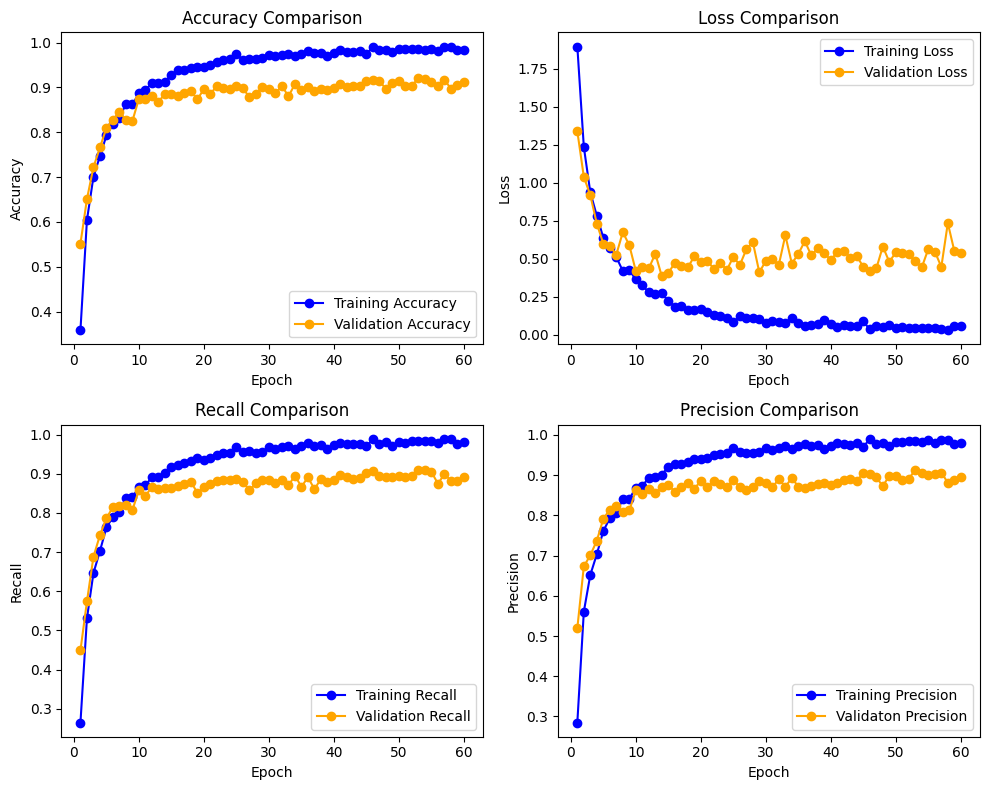

In [8]:
epochs = range(1, EPOCHS + 1)
# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot accuracy
axs[0, 0].plot(epochs, train_accuracy_list, label = 'Training Accuracy', color='blue', marker='o')
axs[0, 0].plot(epochs, val_accuracy_list, label='Validation Accuracy', color='orange', marker='o')
axs[0, 0].set_title('Accuracy Comparison')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend()

# Plot loss
axs[0, 1].plot(epochs, train_loss_list, label = 'Training Loss', color='blue', marker='o')
axs[0, 1].plot(epochs, val_loss_list, label='Validation Loss', color='orange', marker='o')
axs[0, 1].set_title('Loss Comparison')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()

# Plot recall
axs[1, 0].plot(epochs, train_recall_list, label = 'Training Recall', color='blue', marker='o')
axs[1, 0].plot(epochs, val_recall_list, label= 'Validation Recall', color='orange', marker='o')
axs[1, 0].set_title('Recall Comparison')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Recall')
axs[1, 0].legend()

# Plot precision
axs[1, 1].plot(epochs, train_precision_list, label = 'Training Precision', color='blue', marker='o')
axs[1, 1].plot(epochs, val_precision_list, label='Validaton Precision', color='orange', marker='o')
axs[1, 1].set_title('Precision Comparison')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Precision')
axs[1, 1].legend()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()